# Citation

Please cite this notebook as follows.

Lagerquist, R., and D.J. Gagne II, 2019: "Interpretation of deep-learning models for predicting thunderstorm rotation: Python tutorial". https://github.com/djgagne/ams-ml-python-course/blob/ryan_branch/module_4/ML_Short_Course_Module_4_Interpretation.ipynb.

The first use of this notebook was for a short course ([Machine Learning in Python for Environmental Science Problems](https://annual.ametsoc.org/index.cfm/2019/programs/short-courses-workshops/machine-learning-in-python-for-environmental-science-problems/)) at the American Meteorological Society's (AMS) 2019 annual meeting.

# Setup

To use this notebook, you will need Python 3.6 and the following packages.

 - scipy
 - TensorFlow
 - Keras
 - scikit-image
 - netCDF4
 - pyproj
 - scikit-learn
 - opencv-python
 - matplotlib
 - shapely
 - geopy
 - metpy
 - descartes

If you have Anaconda on a Linux or Mac, you can install these packages with the following commands.

`pip install scipy`

`pip install tensorflow`

`pip install keras`

`pip install scikit-image`

`pip install netCDF4`

`pip install pyproj`

`pip install scikit-learn`

`pip install opencv-python`

`pip install matplotlib`

`pip install shapely`

`pip install geopy`

`pip install metpy`

`pip install descartes`

# Imports

The next cell imports all libraries that will be used by this notebook.  If the notebook crashes anywhere, it will probably be here.

In [45]:
%matplotlib inline
import copy
import glob
import errno
import random
import os.path
import pickle
import time
import calendar
import numpy
import pandas
import netCDF4
import keras
from keras import backend as K
from sklearn.metrics import auc as scikit_learn_auc
import matplotlib.colors
import matplotlib.pyplot as pyplot
from module_4 import keras_metrics
from module_4 import roc_curves
from module_4 import performance_diagrams
from module_4 import attributes_diagrams

# Prevent Auto-scrolling

The next cell prevents output in the notebook from being nested in a scroll box (the scroll box is small and makes things hard to see).

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Directories

The next cell defines input and output directories.  You will probably want to change these.

In [4]:
DEFAULT_IMAGE_DIR_NAME = (
    '/home/ryan.lagerquist/Downloads/ams2019_short_course/'
    'track_data_ncar_ams_3km_nc_small')
DEFAULT_FEATURE_DIR_NAME = (
    '/home/ryan.lagerquist/Downloads/ams2019_short_course/'
    'track_data_ncar_ams_3km_csv_small')
DEFAULT_OUTPUT_DIR_NAME = '/home/ryan.lagerquist/Downloads/ams2019_short_course'

# Plotting Constants

The next cell defines constants for plotting figures.  I don't recommend changing any of these &ndash; unless the figures are too big on your screen, in which case you should change `FIGURE_WIDTH_INCHES` and `FIGURE_HEIGHT_INCHES`.

In [5]:
FIGURE_WIDTH_INCHES = 15
FIGURE_HEIGHT_INCHES = 15
FIGURE_RESOLUTION_DPI = 300

BAR_GRAPH_FACE_COLOUR = numpy.array([166, 206, 227], dtype=float) / 255
BAR_GRAPH_EDGE_COLOUR = numpy.full(3, 0.)
BAR_GRAPH_EDGE_WIDTH = 2.

FONT_SIZE = 30
pyplot.rc('font', size=FONT_SIZE)
pyplot.rc('axes', titlesize=FONT_SIZE)
pyplot.rc('axes', labelsize=FONT_SIZE)
pyplot.rc('xtick', labelsize=FONT_SIZE)
pyplot.rc('ytick', labelsize=FONT_SIZE)
pyplot.rc('legend', fontsize=FONT_SIZE)
pyplot.rc('figure', titlesize=FONT_SIZE)

# Naming Constants

The next cell defines variable names in the input (CSV and NetCDF) files and keys in dictionaries created by this notebook.  Don't change any of these.

In [6]:
CSV_METADATA_COLUMNS = [
    'Step_ID', 'Track_ID', 'Ensemble_Name', 'Ensemble_Member', 'Run_Date',
    'Valid_Date', 'Forecast_Hour', 'Valid_Hour_UTC'
]

CSV_EXTRANEOUS_COLUMNS = [
    'Duration', 'Centroid_Lon', 'Centroid_Lat', 'Centroid_X', 'Centroid_Y',
    'Storm_Motion_U', 'Storm_Motion_V', 'Matched', 'Max_Hail_Size',
    'Num_Matches', 'Shape', 'Location', 'Scale'
]

CSV_TARGET_NAME = 'RVORT1_MAX-future_max'
TARGET_NAME = 'max_future_vorticity_s01'

NETCDF_REFL_NAME = 'REFL_COM_curr'
NETCDF_TEMP_NAME = 'T2_curr'
NETCDF_U_WIND_NAME = 'U10_curr'
NETCDF_V_WIND_NAME = 'V10_curr'
NETCDF_PREDICTOR_NAMES = [
    NETCDF_REFL_NAME, NETCDF_TEMP_NAME, NETCDF_U_WIND_NAME, NETCDF_V_WIND_NAME
]

REFLECTIVITY_NAME = 'reflectivity_dbz'
TEMPERATURE_NAME = 'temperature_kelvins'
U_WIND_NAME = 'u_wind_m_s01'
V_WIND_NAME = 'v_wind_m_s01'
PREDICTOR_NAMES = [
    REFLECTIVITY_NAME, TEMPERATURE_NAME, U_WIND_NAME, V_WIND_NAME
]

NETCDF_TRACK_ID_NAME = 'track_id'
NETCDF_TRACK_STEP_NAME = 'track_step'
NETCDF_TARGET_NAME = 'RVORT1_MAX_future'

NUM_VALUES_KEY = 'num_values'
MEAN_VALUE_KEY = 'mean_value'
MEAN_OF_SQUARES_KEY = 'mean_of_squares'

STORM_IDS_KEY = 'storm_ids'
STORM_STEPS_KEY = 'storm_steps'
PREDICTOR_NAMES_KEY = 'predictor_names'
PREDICTOR_MATRIX_KEY = 'predictor_matrix'
TARGET_NAME_KEY = 'target_name'
TARGET_MATRIX_KEY = 'target_matrix'

TRAINING_FILES_KEY = 'training_file_names'
NORMALIZATION_DICT_KEY = 'normalization_dict'
BINARIZATION_THRESHOLD_KEY = 'binarization_threshold'
NUM_EXAMPLES_PER_BATCH_KEY = 'num_examples_per_batch'
NUM_TRAINING_BATCHES_KEY = 'num_training_batches_per_epoch'
VALIDATION_FILES_KEY = 'validation_file_names'
NUM_VALIDATION_BATCHES_KEY = 'num_validation_batches_per_epoch'

PERMUTED_PREDICTORS_KEY = 'permuted_predictor_name_by_step'
HIGHEST_COSTS_KEY = 'highest_cost_by_step'
ORIGINAL_COST_KEY = 'original_cost'
STEP1_PREDICTORS_KEY = 'predictor_names_step1'
STEP1_COSTS_KEY = 'costs_step1'

# More Plotting Constants

In [55]:
THIS_COLOUR_LIST = [
    numpy.array([4, 233, 231]), numpy.array([1, 159, 244]),
    numpy.array([3, 0, 244]), numpy.array([2, 253, 2]),
    numpy.array([1, 197, 1]), numpy.array([0, 142, 0]),
    numpy.array([253, 248, 2]), numpy.array([229, 188, 0]),
    numpy.array([253, 149, 0]), numpy.array([253, 0, 0]),
    numpy.array([212, 0, 0]), numpy.array([188, 0, 0]),
    numpy.array([248, 0, 253]), numpy.array([152, 84, 198])
]

for p in range(len(THIS_COLOUR_LIST)):
    THIS_COLOUR_LIST[p] = THIS_COLOUR_LIST[p].astype(float) / 255

REFL_COLOUR_MAP_OBJECT = matplotlib.colors.ListedColormap(THIS_COLOUR_LIST)
REFL_COLOUR_MAP_OBJECT.set_under(numpy.ones(3))

PREDICTOR_TO_COLOUR_MAP_DICT = {
    TEMPERATURE_NAME: pyplot.cm.YlOrRd,
    REFLECTIVITY_NAME: REFL_COLOUR_MAP_OBJECT
}

THESE_COLOUR_BOUNDS = numpy.array(
    [0.1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70])
REFL_COLOUR_NORM_OBJECT = matplotlib.colors.BoundaryNorm(
    THESE_COLOUR_BOUNDS, REFL_COLOUR_MAP_OBJECT.N)

# Deep-learning Constants

The next cell defines constants used by the deep-learning models.  Unless you know what you're doing, don't change any of these.

In [43]:
L1_WEIGHT = 0.
L2_WEIGHT = 0.001
NUM_PREDICTORS_TO_FIRST_NUM_FILTERS = 8
NUM_CONV_LAYER_SETS = 2
NUM_CONV_LAYERS_PER_SET = 2
NUM_CONV_FILTER_ROWS = 3
NUM_CONV_FILTER_COLUMNS = 3
CONV_LAYER_DROPOUT_FRACTION = None
USE_BATCH_NORMALIZATION = True
SLOPE_FOR_RELU = 0.2
NUM_POOLING_ROWS = 2
NUM_POOLING_COLUMNS = 2
NUM_DENSE_LAYERS = 3
DENSE_LAYER_DROPOUT_FRACTION = 0.5

MIN_LOSS_DECR_FOR_EARLY_STOPPING = 0.005
NUM_EPOCHS_FOR_EARLY_STOPPING = 5

LIST_OF_METRIC_FUNCTIONS = [
    keras_metrics.accuracy, keras_metrics.binary_accuracy,
    keras_metrics.binary_csi, keras_metrics.binary_frequency_bias,
    keras_metrics.binary_pod, keras_metrics.binary_pofd,
    keras_metrics.binary_peirce_score, keras_metrics.binary_success_ratio,
    keras_metrics.binary_focn
]

DEFAULT_NUM_BWO_ITERATIONS = 200
DEFAULT_BWO_LEARNING_RATE = 0.01

# Miscellaneous Constants

The next cell defines miscellaneous constants.  Don't change any of these.

In [54]:
SEPARATOR_STRING = '\n\n' + '*' * 50 + '\n\n'
MINOR_SEPARATOR_STRING = '\n\n' + '-' * 50 + '\n\n'

DATE_FORMAT = '%Y%m%d'
DATE_FORMAT_REGEX = '[0-9][0-9][0-9][0-9][0-1][0-9][0-3][0-9]'

MIN_PROBABILITY = 1e-15
MAX_PROBABILITY = 1. - MIN_PROBABILITY
METRES_PER_SECOND_TO_KT = 3.6 / 1.852

# Time Conversion

The next cell defines methods that convert between different time formats.  One converts from a string to Unix time, and the other converts from Unix time to a string.

A string is just a sequence of characters, like "20190106" or "Jan 6 2019".

Unix time is the number of seconds elapsed since 0000 UTC 1 Jan 1970.  Note that both `time_string_to_unix` and `time_unix_to_string` do not handle time zones other than UTC.

In [9]:
def time_string_to_unix(time_string, time_format):
    """Converts time from string to Unix format.

    Unix format = seconds since 0000 UTC 1 Jan 1970.

    :param time_string: Time string.
    :param time_format: Format of time string (example: "%Y%m%d" or
        "%Y-%m-%d-%H%M%S").
    :return: unix_time_sec: Time in Unix format.
    """

    return calendar.timegm(time.strptime(time_string, time_format))


def time_unix_to_string(unix_time_sec, time_format):
    """Converts time from Unix format to string.

    Unix format = seconds since 0000 UTC 1 Jan 1970.

    :param unix_time_sec: Time in Unix format.
    :param time_format: Desired format of time string (example: "%Y%m%d" or
        "%Y-%m-%d-%H%M%S").
    :return: time_string: Time string.
    """

    return time.strftime(time_format, time.gmtime(unix_time_sec))

# Feature Files

The next cell defines methods that locate and read feature (CSV) files.  A "feature file" contains derived features for all storm objects on one day.  A "storm object" is one thunderstorm cell at one time step.  A "derived feature" is a single number (statistic) calculated from the gridded model variables, which include simulated radar reflectivity, temperature, $u$-wind, and $v$-wind.

In [10]:
def _remove_future_data(predictor_table):
    """Removes future data from predictors.

    :param predictor_table: pandas DataFrame with predictor values.  Each row is
        one storm object.
    :return: predictor_table: Same but with fewer columns.
    """

    predictor_names = list(predictor_table)
    columns_to_remove = [p for p in predictor_names if 'future' in p]

    return predictor_table.drop(columns_to_remove, axis=1, inplace=False)


def _feature_file_name_to_date(csv_file_name):
    """Parses date from name of feature (CSV) file.

    :param csv_file_name: Path to input file.
    :return: date_string: Date (format "yyyymmdd").
    """

    pathless_file_name = os.path.split(csv_file_name)[-1]
    date_string = pathless_file_name.replace(
        'track_step_NCARSTORM_d01_', '').replace('-0000.csv', '')

    # Verify.
    time_string_to_unix(time_string=date_string, time_format=DATE_FORMAT)
    return date_string

def find_many_feature_files(first_date_string, last_date_string,
                            feature_dir_name=DEFAULT_FEATURE_DIR_NAME):
    """Finds feature files in the given date range.

    :param first_date_string: First date ("yyyymmdd") in range.
    :param last_date_string: Last date ("yyyymmdd") in range.
    :param feature_dir_name: Name of directory with feature (CSV) files.
    :return: csv_file_names: 1-D list of paths to feature files.
    """

    first_time_unix_sec = time_string_to_unix(
        time_string=first_date_string, time_format=DATE_FORMAT)
    last_time_unix_sec = time_string_to_unix(
        time_string=last_date_string, time_format=DATE_FORMAT)

    csv_file_pattern = '{0:s}/track_step_NCARSTORM_d01_{1:s}-0000.csv'.format(
        feature_dir_name, DATE_FORMAT_REGEX)
    csv_file_names = glob.glob(csv_file_pattern)
    csv_file_names.sort()

    file_date_strings = [_feature_file_name_to_date(f) for f in csv_file_names]
    file_times_unix_sec = numpy.array([
        time_string_to_unix(time_string=d, time_format=DATE_FORMAT)
        for d in file_date_strings
    ], dtype=int)

    good_indices = numpy.where(numpy.logical_and(
        file_times_unix_sec >= first_time_unix_sec,
        file_times_unix_sec <= last_time_unix_sec
    ))[0]

    return [csv_file_names[k] for k in good_indices]


def read_feature_file(csv_file_name):
    """Reads features from CSV file.

    :param csv_file_name: Path to input file.
    :return: metadata_table: pandas DataFrame with metadata.  Each row is one
        storm object.
    :return: predictor_table: pandas DataFrame with predictor values.  Each row
        is one storm object.
    :return: target_table: pandas DataFrame with target values.  Each row is one
        storm object.
    """

    predictor_table = pandas.read_csv(csv_file_name, header=0, sep=',')
    predictor_table.drop(CSV_EXTRANEOUS_COLUMNS, axis=1, inplace=True)

    metadata_table = predictor_table[CSV_METADATA_COLUMNS]
    predictor_table.drop(CSV_METADATA_COLUMNS, axis=1, inplace=True)

    target_table = predictor_table[[CSV_TARGET_NAME]]
    predictor_table.drop([CSV_TARGET_NAME], axis=1, inplace=True)
    predictor_table = _remove_future_data(predictor_table)

    return metadata_table, predictor_table, target_table


def read_many_feature_files(csv_file_names):
    """Reads features from many CSV files.

    :param csv_file_names: 1-D list of paths to input files.
    :return: metadata_table: See doc for `read_feature_file`.
    :return: predictor_table: Same.
    :return: target_table: Same.
    """

    num_files = len(csv_file_names)
    list_of_metadata_tables = [pandas.DataFrame()] * num_files
    list_of_predictor_tables = [pandas.DataFrame()] * num_files
    list_of_target_tables = [pandas.DataFrame()] * num_files

    for i in range(num_files):
        print('Reading data from: "{0:s}"...'.format(csv_file_names[i]))

        (list_of_metadata_tables[i], list_of_predictor_tables[i],
         list_of_target_tables[i]
        ) = read_feature_file(csv_file_names[i])

        if i == 0:
            continue

        list_of_metadata_tables[i] = list_of_metadata_tables[i].align(
            list_of_metadata_tables[0], axis=1
        )[0]

        list_of_predictor_tables[i] = list_of_predictor_tables[i].align(
            list_of_predictor_tables[0], axis=1
        )[0]

        list_of_target_tables[i] = list_of_target_tables[i].align(
            list_of_target_tables[0], axis=1
        )[0]

    metadata_table = pandas.concat(
        list_of_metadata_tables, axis=0, ignore_index=True)
    predictor_table = pandas.concat(
        list_of_predictor_tables, axis=0, ignore_index=True)
    target_table = pandas.concat(
        list_of_target_tables, axis=0, ignore_index=True)

    return metadata_table, predictor_table, target_table

# Feature Files: Example

The next cell finds and reads features for all storm objects in July 2015.

In [11]:
feature_file_names = find_many_feature_files(
    first_date_string='20150701', last_date_string='20150731')
metadata_table, predictor_table, target_table = read_many_feature_files(
    feature_file_names)

print(MINOR_SEPARATOR_STRING)
print('Variables in metadata are as follows:')
for this_column in list(metadata_table):
    print(this_column)

print('\nPredictor variables are as follows:')
for this_column in list(predictor_table):
    print(this_column)

print('\nTarget variables are as follows:')
for this_column in list(target_table):
    print(this_column)

this_predictor_name = list(predictor_table)[0]
these_predictor_values = predictor_table[this_predictor_name].values[:10]
print('\nSome values of predictor variable "{0:s}":\n{1:s}'.format(
    this_predictor_name, str(these_predictor_values)
))

this_target_name = list(target_table)[0]
these_target_values = target_table[this_target_name].values[:10]
print('\nSome values of target variable "{0:s}":\n{1:s}'.format(
    this_target_name, str(these_target_values)
))

Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20150706-0000.csv"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20150712-0000.csv"...


--------------------------------------------------


Variables in metadata are as follows:
Step_ID
Track_ID
Ensemble_Name
Ensemble_Member
Run_Date
Valid_Date
Forecast_Hour
Valid_Hour_UTC

Predictor variables are as follows:
REFL_COM_mean
REFL_COM_max
REFL_COM_min
REFL_COM_std
REFL_COM_percentile_10
REFL_COM_percentile_25
REFL_COM_percentile_50
REFL_COM_percentile_75
REFL_COM_percentile_90
U10_mean
U10_max
U10_min
U10_std
U10_percentile_10
U10_percentile_25
U10_percentile_50
U10_percentile_75
U10_percentile_90
V10_mean
V10_max
V10_min
V10_std
V10_percentile_10
V10_percentile_25
V10_percentile_50
V10_percentile_75
V10_percentile_90
T2_mean
T2_max
T2_min
T2_std
T2_percentile_10
T2_per

# Image Files

The next cell defines methods that locate and read image (NetCDF) files.  An "image file" contains storm-centered grids of several model variables &ndash; including simulated radar reflectivity (henceforth, just "reflectivity"), temperature, $u$-wind, and $v$-wind &ndash; for all storm objects on one day.  In other words, these files contain raw data as opposed to derived features.

In [12]:
def _image_file_name_to_date(netcdf_file_name):
    """Parses date from name of image (NetCDF) file.

    :param netcdf_file_name: Path to input file.
    :return: date_string: Date (format "yyyymmdd").
    """

    pathless_file_name = os.path.split(netcdf_file_name)[-1]
    date_string = pathless_file_name.replace(
        'NCARSTORM_', '').replace('-0000_d01_model_patches.nc', '')

    # Verify.
    time_string_to_unix(time_string=date_string, time_format=DATE_FORMAT)
    return date_string

def find_many_image_files(first_date_string, last_date_string,
                          image_dir_name=DEFAULT_IMAGE_DIR_NAME):
    """Finds image (NetCDF) files in the given date range.

    :param first_date_string: First date ("yyyymmdd") in range.
    :param last_date_string: Last date ("yyyymmdd") in range.
    :param image_dir_name: Name of directory with image (NetCDF) files.
    :return: netcdf_file_names: 1-D list of paths to image files.
    """

    first_time_unix_sec = time_string_to_unix(
        time_string=first_date_string, time_format=DATE_FORMAT)
    last_time_unix_sec = time_string_to_unix(
        time_string=last_date_string, time_format=DATE_FORMAT)

    netcdf_file_pattern = (
        '{0:s}/NCARSTORM_{1:s}-0000_d01_model_patches.nc'
    ).format(image_dir_name, DATE_FORMAT_REGEX)

    netcdf_file_names = glob.glob(netcdf_file_pattern)
    netcdf_file_names.sort()

    file_date_strings = [_image_file_name_to_date(f) for f in netcdf_file_names]
    file_times_unix_sec = numpy.array([
        time_string_to_unix(time_string=d, time_format=DATE_FORMAT)
        for d in file_date_strings
    ], dtype=int)

    good_indices = numpy.where(numpy.logical_and(
        file_times_unix_sec >= first_time_unix_sec,
        file_times_unix_sec <= last_time_unix_sec
    ))[0]

    return [netcdf_file_names[k] for k in good_indices]


def read_image_file(netcdf_file_name):
    """Reads storm-centered images from NetCDF file.

    E = number of examples (storm objects) in file
    M = number of rows in each storm-centered grid
    N = number of columns in each storm-centered grid
    C = number of channels (predictor variables)

    :param netcdf_file_name: Path to input file.
    :return: image_dict: Dictionary with the following keys.
    image_dict['storm_ids']: length-E list of storm IDs (integers).
    image_dict['storm_steps']: length-E numpy array of storm steps (integers).
    image_dict['predictor_names']: length-C list of predictor names.
    image_dict['predictor_matrix']: E-by-M-by-N-by-C numpy array of predictor
        values.
    image_dict['target_name']: Name of target variable.
    image_dict['target_matrix']: E-by-M-by-N numpy array of target values.
    """

    dataset_object = netCDF4.Dataset(netcdf_file_name)

    storm_ids = numpy.array(
        dataset_object.variables[NETCDF_TRACK_ID_NAME][:], dtype=int)
    storm_steps = numpy.array(
        dataset_object.variables[NETCDF_TRACK_STEP_NAME][:], dtype=int)

    predictor_matrix = None

    for this_predictor_name in NETCDF_PREDICTOR_NAMES:
        this_predictor_matrix = numpy.array(
            dataset_object.variables[this_predictor_name][:], dtype=float)
        this_predictor_matrix = numpy.expand_dims(
            this_predictor_matrix, axis=-1)

        if predictor_matrix is None:
            predictor_matrix = this_predictor_matrix + 0.
        else:
            predictor_matrix = numpy.concatenate(
                (predictor_matrix, this_predictor_matrix), axis=-1)

    target_matrix = numpy.array(
        dataset_object.variables[NETCDF_TARGET_NAME][:], dtype=float)

    return {
        STORM_IDS_KEY: storm_ids,
        STORM_STEPS_KEY: storm_steps,
        PREDICTOR_NAMES_KEY: PREDICTOR_NAMES,
        PREDICTOR_MATRIX_KEY: predictor_matrix,
        TARGET_NAME_KEY: TARGET_NAME,
        TARGET_MATRIX_KEY: target_matrix
    }


def read_many_image_files(netcdf_file_names):
    """Reads storm-centered images from many NetCDF files.

    :param netcdf_file_names: 1-D list of paths to input files.
    :return: image_dict: See doc for `read_image_file`.
    """

    image_dict = None
    keys_to_concat = [
        STORM_IDS_KEY, STORM_STEPS_KEY, PREDICTOR_MATRIX_KEY, TARGET_MATRIX_KEY
    ]

    for this_file_name in netcdf_file_names:
        print('Reading data from: "{0:s}"...'.format(this_file_name))
        this_image_dict = read_image_file(this_file_name)

        if image_dict is None:
            image_dict = copy.deepcopy(this_image_dict)
            continue

        for this_key in keys_to_concat:
            image_dict[this_key] = numpy.concatenate(
                (image_dict[this_key], this_image_dict[this_key]), axis=0)

    return image_dict

# Image Files: Example 1

The next cell finds and reads images for all storm objects in July 2015.

In [13]:
image_file_names = find_many_image_files(
    first_date_string='20150701', last_date_string='20150731')
image_dict = read_many_image_files(image_file_names)

print(MINOR_SEPARATOR_STRING)
print('Variables in dictionary are as follows:')
for this_key in image_dict.keys():
    print(this_key)

print('\nPredictor variables are as follows:')
predictor_names = image_dict[PREDICTOR_NAMES_KEY]
for this_name in predictor_names:
    print(this_name)

these_predictor_values = image_dict[PREDICTOR_MATRIX_KEY][0, :5, :5, 0]
print(
    ('\nSome values of predictor variable "{0:s}" for first storm object:'
     '\n{1:s}'
     ).format(predictor_names[0], str(these_predictor_values))
)

these_target_values = image_dict[TARGET_MATRIX_KEY][0, :5, :5]
print(
    ('\nSome values of target variable "{0:s}" for first storm object:'
     '\n{1:s}'
     ).format(image_dict[TARGET_NAME_KEY], str(these_target_values))
)

Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150706-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150712-0000_d01_model_patches.nc"...


--------------------------------------------------


Variables in dictionary are as follows:
storm_ids
storm_steps
predictor_names
predictor_matrix
target_name
target_matrix

Predictor variables are as follows:
reflectivity_dbz
temperature_kelvins
u_wind_m_s01
v_wind_m_s01

Some values of predictor variable "reflectivity_dbz" for first storm object:
[[13.97686386 19.82977104 19.72230339 12.15658951 24.21878624]
 [11.72174263 16.28964233 17.1885643   8.1463623  21.16093636]
 [ 8.37331963 13.1016016  13.51956081  4.92564344 15.90840054]
 [ 1.74170113 11.59834766  7.84896898  0.69869119  4.64704037]
 [ 6.33569193  7.28762817  7.5872879   8.06334972 10.47385979]]

Some values of targ

# Training Files

The next cell finds and reads training files (images from 2010-2014) for deep learning.

In [14]:
training_file_names = find_many_image_files(
    first_date_string='20100101', last_date_string='20141231')

# Normalization Parameters

The next cell defines methods that find the normalization parameters (mean and standard deviation of each model variable) over a large number of files.  The means and standard deviations are updated iteratively (whenever a new file is read), which obviates the need to load all files into memory at once.  This would take up several GB of memory and potentially crash the notebook.

In [15]:
def _update_normalization_params(intermediate_normalization_dict, new_values):
    """Updates normalization params for one predictor.

    :param intermediate_normalization_dict: Dictionary with the following keys.
    intermediate_normalization_dict['num_values']: Number of values on which
        current estimates are based.
    intermediate_normalization_dict['mean_value']: Current estimate for mean.
    intermediate_normalization_dict['mean_of_squares']: Current mean of squared
        values.

    :param new_values: numpy array of new values (will be used to update
        `intermediate_normalization_dict`).
    :return: intermediate_normalization_dict: Same as input but with updated
        values.
    """

    if MEAN_VALUE_KEY not in intermediate_normalization_dict:
        intermediate_normalization_dict = {
            NUM_VALUES_KEY: 0,
            MEAN_VALUE_KEY: 0.,
            MEAN_OF_SQUARES_KEY: 0.
        }

    these_means = numpy.array([
        intermediate_normalization_dict[MEAN_VALUE_KEY], numpy.mean(new_values)
    ])
    these_weights = numpy.array([
        intermediate_normalization_dict[NUM_VALUES_KEY], new_values.size
    ])

    intermediate_normalization_dict[MEAN_VALUE_KEY] = numpy.average(
        these_means, weights=these_weights)

    these_means = numpy.array([
        intermediate_normalization_dict[MEAN_OF_SQUARES_KEY],
        numpy.mean(new_values ** 2)
    ])

    intermediate_normalization_dict[MEAN_OF_SQUARES_KEY] = numpy.average(
        these_means, weights=these_weights)

    intermediate_normalization_dict[NUM_VALUES_KEY] += new_values.size
    return intermediate_normalization_dict


def _get_standard_deviation(intermediate_normalization_dict):
    """Computes stdev from intermediate normalization params.

    :param intermediate_normalization_dict: See doc for
        `_update_normalization_params`.
    :return: standard_deviation: Standard deviation.
    """

    num_values = float(intermediate_normalization_dict[NUM_VALUES_KEY])
    multiplier = num_values / (num_values - 1)

    return numpy.sqrt(multiplier * (
        intermediate_normalization_dict[MEAN_OF_SQUARES_KEY] -
        intermediate_normalization_dict[MEAN_VALUE_KEY] ** 2
    ))


def get_image_normalization_params(netcdf_file_names):
    """Computes normalization params (mean and stdev) for each predictor.

    :param netcdf_file_names: 1-D list of paths to input files.
    :return: normalization_dict: See input doc for `normalize_images`.
    """

    predictor_names = None
    norm_dict_by_predictor = None

    for this_file_name in netcdf_file_names:
        print('Reading data from: "{0:s}"...'.format(this_file_name))
        this_image_dict = read_image_file(this_file_name)

        if predictor_names is None:
            predictor_names = this_image_dict[PREDICTOR_NAMES_KEY]
            norm_dict_by_predictor = [{}] * len(predictor_names)

        for m in range(len(predictor_names)):
            norm_dict_by_predictor[m] = _update_normalization_params(
                intermediate_normalization_dict=norm_dict_by_predictor[m],
                new_values=this_image_dict[PREDICTOR_MATRIX_KEY][..., m])

    print('\n')
    normalization_dict = {}

    for m in range(len(predictor_names)):
        this_mean = norm_dict_by_predictor[m][MEAN_VALUE_KEY]
        this_stdev = _get_standard_deviation(norm_dict_by_predictor[m])
        normalization_dict[predictor_names[m]] = numpy.array(
            [this_mean, this_stdev])

        print(
            ('Mean and standard deviation for "{0:s}" = {1:.4f}, {2:.4f}'
             ).format(predictor_names[m], this_mean, this_stdev)
        )

    return normalization_dict

# Normalization Parameters: Example

The next cell computes the normalization parameters that will be used throughout this notebook.  Normalization parameters should be computed only on the training data, and the same parameters should be used to normalize any other data (*e.g.*, validation data, testing data, or future data in an operational forecasting application).

In [16]:
normalization_dict = get_image_normalization_params(training_file_names)

Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101024-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101122-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110201-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110308-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110326-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110404-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_cour

Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140514-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140526-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140604-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140609-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140617-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140622-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_cour

# Normalization and Denormalization

The next cell defines methods that normalize and denormalize images.

In [17]:
def normalize_images(
        predictor_matrix, predictor_names, normalization_dict=None):
    """Normalizes images to z-scores.

    E = number of examples (storm objects) in file
    M = number of rows in each storm-centered grid
    N = number of columns in each storm-centered grid
    C = number of channels (predictor variables)

    :param predictor_matrix: E-by-M-by-N-by-C numpy array of predictor values.
    :param predictor_names: length-C list of predictor names.
    :param normalization_dict: Dictionary.  Each key is the name of a predictor
        value, and the corresponding value is a length-2 numpy array with
        [mean, standard deviation].  If `normalization_dict is None`, mean and
        standard deviation will be computed for each predictor.
    :return: predictor_matrix: Normalized version of input.
    :return: normalization_dict: See doc for input variable.  If input was None,
        this will be a newly created dictionary.  Otherwise, this will be the
        same dictionary passed as input.
    """

    num_predictors = len(predictor_names)

    if normalization_dict is None:
        normalization_dict = {}

        for m in range(num_predictors):
            this_mean = numpy.mean(predictor_matrix[..., m])
            this_stdev = numpy.std(predictor_matrix[..., m], ddof=1)

            normalization_dict[predictor_names[m]] = numpy.array(
                [this_mean, this_stdev])

    for m in range(num_predictors):
        this_mean = normalization_dict[predictor_names[m]][0]
        this_stdev = normalization_dict[predictor_names[m]][1]

        predictor_matrix[..., m] = (
            (predictor_matrix[..., m] - this_mean) / this_stdev
        )

    return predictor_matrix, normalization_dict


def denormalize_images(predictor_matrix, predictor_names, normalization_dict):
    """Denormalizes images from z-scores back to original scales.

    :param predictor_matrix: See doc for `normalize_images`.
    :param predictor_names: Same.
    :param normalization_dict: Same.
    :return: predictor_matrix: Denormalized version of input.
    """

    num_predictors = len(predictor_names)
    for m in range(num_predictors):
        this_mean = normalization_dict[predictor_names[m]][0]
        this_stdev = normalization_dict[predictor_names[m]][1]

        predictor_matrix[..., m] = (
            this_mean + this_stdev * predictor_matrix[..., m]
        )

    return predictor_matrix

# Normalization and Denormalization: Example

The next cell normalizes and denormalizes images from one file.  The denormalized values should be exactly equal to the original values.

In [18]:
image_dict = read_image_file(training_file_names[0])

predictor_names = image_dict[PREDICTOR_NAMES_KEY]
these_predictor_values = image_dict[PREDICTOR_MATRIX_KEY][0, :5, :5, 0]

print('\nOriginal values of "{0:s}" for first storm object:\n{1:s}'.format(
    predictor_names[0], str(these_predictor_values)
))

image_dict[PREDICTOR_MATRIX_KEY], _ = normalize_images(
    predictor_matrix=image_dict[PREDICTOR_MATRIX_KEY],
    predictor_names=predictor_names, normalization_dict=normalization_dict)

these_predictor_values = image_dict[PREDICTOR_MATRIX_KEY][0, :5, :5, 0]
print(
    '\nNormalized values of "{0:s}" for first storm object:\n{1:s}'.format(
        predictor_names[0], str(these_predictor_values))
)

image_dict[PREDICTOR_MATRIX_KEY] = denormalize_images(
    predictor_matrix=image_dict[PREDICTOR_MATRIX_KEY],
    predictor_names=predictor_names, normalization_dict=normalization_dict)

these_predictor_values = image_dict[PREDICTOR_MATRIX_KEY][0, :5, :5, 0]
print(
    ('\nDenormalized values of "{0:s}" for first storm object:\n{1:s}'
     ).format(predictor_names[0], str(these_predictor_values))
)


Original values of "reflectivity_dbz" for first storm object:
[[ 0.          6.9651885   6.99899673  3.64286256  0.        ]
 [ 1.818367    4.22854471  0.28074482  0.          0.        ]
 [ 7.24424314  4.46407127  0.          0.          0.        ]
 [16.65088844 18.46622086 17.29220772 13.19463634  2.80103612]
 [19.96715736 22.98410988 23.0850563  19.88584709 11.70358849]]

Normalized values of "reflectivity_dbz" for first storm object:
[[-1.43928327 -0.99737685 -0.99523189 -1.20816184 -1.43928327]
 [-1.32391697 -1.17100323 -1.42147142 -1.43928327 -1.43928327]
 [-0.97967223 -1.15606025 -1.43928327 -1.43928327 -1.43928327]
 [-0.38286757 -0.2676938  -0.34217907 -0.6021495  -1.26157152]
 [-0.17246687  0.0189437   0.02534824 -0.1776256  -0.69674904]]

Denormalized values of "reflectivity_dbz" for first storm object:
[[ 0.          6.9651885   6.99899673  3.64286256  0.        ]
 [ 1.818367    4.22854471  0.28074482  0.          0.        ]
 [ 7.24424314  4.46407127  0.          0.      

# Binarization Threshold

The next cell defines a method that finds the "binarization threshold," used to simplify the target variable (maximum future vorticity within the same storm).  The original target variable is on a $32 \times 32$ grid, where the value at grid cell $(i, j)$ is max future vorticity within the storm at grid cell $(i, j)$.  One could train a deep-learning model to predict max future vorticity at each grid cell, but this would be a regression task with 1024 output variables, which would make the rest of this notebook too complicated for a 1.5-hour tutorial.

To simplify the prediction task, the binarization threshold ($\zeta^*$) is applied to the max future vorticity over all 1024 grid cells.  If this value is $\ge \zeta^*$, the storm object is labeled a "1" or "yes"; otherwise, the storm object is labeled a "0" or "no".  This turns the prediction task into binary classification with only one output variable.

In [19]:
def get_binarization_threshold(netcdf_file_names, percentile_level):
    """Computes binarization threshold for target variable.

    Binarization threshold will be [q]th percentile of all image maxima, where
    q = `percentile_level`.

    :param netcdf_file_names: 1-D list of paths to input files.
    :param percentile_level: q in the above discussion.
    :return: binarization_threshold: Binarization threshold (used to turn each
        target image into a yes-or-no label).
    """

    max_target_values = numpy.array([])

    for this_file_name in netcdf_file_names:
        print('Reading data from: "{0:s}"...'.format(this_file_name))
        this_image_dict = read_image_file(this_file_name)

        this_target_matrix = this_image_dict[TARGET_MATRIX_KEY]
        this_num_examples = this_target_matrix.shape[0]
        these_max_target_values = numpy.full(this_num_examples, numpy.nan)

        for i in range(this_num_examples):
            these_max_target_values[i] = numpy.max(this_target_matrix[i, ...])

        max_target_values = numpy.concatenate((
            max_target_values, these_max_target_values))

    binarization_threshold = numpy.percentile(
        max_target_values, percentile_level)

    print('\nBinarization threshold for "{0:s}" = {1:.4e}'.format(
        TARGET_NAME, binarization_threshold))

    return binarization_threshold

# Binarization Threshold: Example

The next cell computes the binarizarion threshold that will be used throughout this notebook.  The binarization threshold should be computed only on the training data, and the same threshold should be used to binarize any other data (*e.g.*, validation data, testing data, or future data in an operational forecasting application).

In [20]:
binarization_threshold = get_binarization_threshold(
    netcdf_file_names=training_file_names, percentile_level=90.)

Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101024-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101122-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110201-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110308-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110326-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110404-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_cour

Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140514-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140526-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140604-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140609-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140617-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140622-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_cour

# Binarization

The next cell defines the method that actually binarizes images of the target variable.

In [21]:
def binarize_target_images(target_matrix, binarization_threshold):
    """Binarizes target images.

    Specifically, this method turns each target image into a binary label,
    depending on whether or not (max value in image) >= binarization_threshold.

    E = number of examples (storm objects) in file
    M = number of rows in each storm-centered grid
    N = number of columns in each storm-centered grid

    :param target_matrix: E-by-M-by-N numpy array of floats.
    :param binarization_threshold: Binarization threshold.
    :return: target_values: length-E numpy array of target values (integers in
        0...1).
    """

    num_examples = target_matrix.shape[0]
    target_values = numpy.full(num_examples, -1, dtype=int)

    for i in range(num_examples):
        target_values[i] = (
            numpy.max(target_matrix[i, ...]) >= binarization_threshold
        )

    return target_values

# Binarization: Example

The next cell binarizes images from one file.

In [22]:
image_dict = read_image_file(training_file_names[0])
these_max_target_values = numpy.array(
    [numpy.max(image_dict[TARGET_MATRIX_KEY][i, ...]) for i in range(10)]
)

print(
    ('\nSpatial maxima of "{0:s}" for the first few storm objects:\n{1:s}'
     ).format(image_dict[TARGET_NAME_KEY], str(these_max_target_values))
)

target_values = binarize_target_images(
    target_matrix=image_dict[TARGET_MATRIX_KEY],
    binarization_threshold=binarization_threshold)

print(
    ('\nBinarized target values for the first few storm objects:\n{0:s}'
     ).format(str(target_values[:10]))
)


Spatial maxima of "max_future_vorticity_s01" for the first few storm objects:
[0.0021904  0.00241288 0.00241288 0.00245462 0.00258843 0.00216414
 0.001725   0.00137892 0.00147138 0.00117736]

Binarized target values for the first few storm objects:
[0 0 0 0 0 0 0 0 0 0]


# CNN Setup

The next cell defines methods for setting up (but not training a CNN).  "Setting up" means defining the architecture, loss function, and optimizer.  The loss function for classification is almost always cross-entropy, and one of the preferred optimizers in the deep-learning community is Adam, so these are both defaults in the method `setup_cnn`.  The architecture used in `setup_cnn` is much more heuristic &ndash; it is based on my intuition and architectures that have worked for me in similar problems (*e.g.*, front detection where the inputs were $33 \times 33$ grids of temperature, specific humidity, $u$-wind, and $v$-wind).  There is almost undoubtedly a better architecture, so feel free to experiment.

In [24]:
def _get_dense_layer_dimensions(num_input_units, num_classes, num_dense_layers):
    """Returns dimensions (number of input and output units) for each dense lyr.

    D = number of dense layers

    :param num_input_units: Number of input units (features created by
        flattening layer).
    :param num_classes: Number of output classes (possible values of target
        variable).
    :param num_dense_layers: Number of dense layers.
    :return: num_inputs_by_layer: length-D numpy array with number of input
        units by dense layer.
    :return: num_outputs_by_layer: length-D numpy array with number of output
        units by dense layer.
    """

    if num_classes == 2:
        num_output_units = 1
    else:
        num_output_units = num_classes + 0

    e_folding_param = (
        float(-1 * num_dense_layers) /
        numpy.log(float(num_output_units) / num_input_units)
    )

    dense_layer_indices = numpy.linspace(
        0, num_dense_layers - 1, num=num_dense_layers, dtype=float)
    num_inputs_by_layer = num_input_units * numpy.exp(
        -1 * dense_layer_indices / e_folding_param)
    num_inputs_by_layer = numpy.round(num_inputs_by_layer).astype(int)

    num_outputs_by_layer = numpy.concatenate((
        num_inputs_by_layer[1:],
        numpy.array([num_output_units], dtype=int)
    ))

    return num_inputs_by_layer, num_outputs_by_layer


def setup_cnn(num_grid_rows, num_grid_columns):
    """Sets up (but does not train) CNN (convolutional neural net).

    :param num_grid_rows: Number of rows in each predictor image.
    :param num_grid_columns: Number of columns in each predictor image.
    :return: model_object: Untrained instance of `keras.models.Model`.
    """

    regularizer_object = keras.regularizers.l1_l2(l1=L1_WEIGHT, l2=L2_WEIGHT)

    num_predictors = len(NETCDF_PREDICTOR_NAMES)
    input_layer_object = keras.layers.Input(
        shape=(num_grid_rows, num_grid_columns, num_predictors)
    )

    current_num_filters = None
    current_layer_object = None

    # Add convolutional layers.
    for _ in range(NUM_CONV_LAYER_SETS):
        for _ in range(NUM_CONV_LAYERS_PER_SET):

            if current_num_filters is None:
                current_num_filters = (
                    num_predictors * NUM_PREDICTORS_TO_FIRST_NUM_FILTERS)
                this_input_layer_object = input_layer_object

            else:
                current_num_filters *= 2
                this_input_layer_object = current_layer_object

            current_layer_object = keras.layers.Conv2D(
                filters=current_num_filters,
                kernel_size=(NUM_CONV_FILTER_ROWS, NUM_CONV_FILTER_COLUMNS),
                strides=(1, 1), padding='valid', data_format='channels_last',
                dilation_rate=(1, 1), activation=None, use_bias=True,
                kernel_initializer='glorot_uniform', bias_initializer='zeros',
                kernel_regularizer=regularizer_object
            )(this_input_layer_object)

            current_layer_object = keras.layers.LeakyReLU(
                alpha=SLOPE_FOR_RELU
            )(current_layer_object)

            if CONV_LAYER_DROPOUT_FRACTION is not None:
                current_layer_object = keras.layers.Dropout(
                    rate=CONV_LAYER_DROPOUT_FRACTION
                )(current_layer_object)

            if USE_BATCH_NORMALIZATION:
                current_layer_object = keras.layers.BatchNormalization(
                    axis=-1, center=True, scale=True
                )(current_layer_object)

        current_layer_object = keras.layers.MaxPooling2D(
            pool_size=(NUM_POOLING_ROWS, NUM_POOLING_COLUMNS),
            strides=(NUM_POOLING_ROWS, NUM_POOLING_COLUMNS),
            padding='valid', data_format='channels_last'
        )(current_layer_object)

    these_dimensions = numpy.array(
        current_layer_object.get_shape().as_list()[1:], dtype=int)
    num_features = numpy.prod(these_dimensions)

    current_layer_object = keras.layers.Flatten()(current_layer_object)

    # Add intermediate dense layers.
    _, num_outputs_by_dense_layer = _get_dense_layer_dimensions(
        num_input_units=num_features, num_classes=2,
        num_dense_layers=NUM_DENSE_LAYERS)

    for k in range(NUM_DENSE_LAYERS - 1):
        current_layer_object = keras.layers.Dense(
            num_outputs_by_dense_layer[k], activation=None, use_bias=True,
            kernel_initializer='glorot_uniform', bias_initializer='zeros',
            kernel_regularizer=regularizer_object
        )(current_layer_object)

        current_layer_object = keras.layers.LeakyReLU(
            alpha=SLOPE_FOR_RELU
        )(current_layer_object)

        if DENSE_LAYER_DROPOUT_FRACTION is not None:
            current_layer_object = keras.layers.Dropout(
                rate=DENSE_LAYER_DROPOUT_FRACTION
            )(current_layer_object)

        if USE_BATCH_NORMALIZATION:
            current_layer_object = keras.layers.BatchNormalization(
                axis=-1, center=True, scale=True
            )(current_layer_object)

    # Add output layer (also dense).
    current_layer_object = keras.layers.Dense(
        1, activation=None, use_bias=True,
        kernel_initializer='glorot_uniform', bias_initializer='zeros',
        kernel_regularizer=regularizer_object
    )(current_layer_object)

    current_layer_object = keras.layers.Activation(
        'sigmoid'
    )(current_layer_object)

    if DENSE_LAYER_DROPOUT_FRACTION is not None and NUM_DENSE_LAYERS == 1:
        current_layer_object = keras.layers.Dropout(
            rate=DENSE_LAYER_DROPOUT_FRACTION
        )(current_layer_object)

    # Put the whole thing together and compile.
    model_object = keras.models.Model(
        inputs=input_layer_object, outputs=current_layer_object)
    model_object.compile(
        loss=keras.losses.binary_crossentropy,
        optimizer=keras.optimizers.Adam(),
        metrics=LIST_OF_METRIC_FUNCTIONS)

    model_object.summary()
    return model_object

# CNN Setup: Example

The next cell runs `setup_cnn`, which prints the architecture in a plain-text table.  The architecture is easier to understand as an image, shown below (created with [this website](http://alexlenail.me/NN-SVG/AlexNet.html)).  This image shows the effects of the convolutional, pooling, and dense layers, on the dimensions of the model grids as they are passed through the CNN.  The image does **not** show the effects of batch normalization or leaky ReLU (the activation function), because these change only the values in the grids, not the grid dimensions.

 - The input data have dimensions of $32 \times 32 \times 4$ (32 spatial rows, 32 spatial columns, and 4 variables: reflectivity, temperature, $u$-wind, and $v$-wind).

 - After one convolution, the data have dimensions of $30 \times 30 \times 32$ (30 rows, 30 columns, and 32 filters).  A "filter" can be thought of as a transformed input variable (the output of a transformation applied to the 4 original variables).  The grids have fewer rows and columns because the convolution window, which is $3 \times 3$, cannot be applied at the edges of the input.  A $3 \times 3$ convolution always removes 2 rows and 2 columns from the grids.  In general, a $J \times K$ convolution always removes $J - 1$ rows and $K - 1$ columns.

 - After the second convolution, the data have dimensions of $28 \times 28 \times 64$ (28 rows, 28 columns, and 64 filters).  In general, as data are passed through the CNN, the spatial dimensions shrink and the number of filters grows.

 - After the first pooling, the data have dimensions of $14 \times 14 \times 64$.  The $2 \times 2$ pooling window cuts the spatial dimensions in half.  In general, a $J \times K$ pooling window cuts the number of rows by a factor of $J$ and number of columns by a factor of $K$.  This CNN uses max-pooling, where each output value in filter $F$ is the maximum input $F$-value inside the pooling window.  You can also use mean-pooling.  Pooling allows deeper layers (to the right) to detect larger-scale features than shallower layers (to the left).  Both small-scale and large-scale features may be important to the prediction task.

 - The next convolution changes the dimensions to $12 \times 12 \times 128$.

 - The next convolution changes the dimensions to $10 \times 10 \times 256$.

 - The next pooling changes the dimensions to $5 \times 5 \times 256$.

 - The 256 images ("feature maps") are flattened into a length-6400 vector.

 - The first dense layer (or "fully connected" layer; this is the same as a hidden layer in a traditional neural net) transforms the 6400 scalar features into 345 scalar features.

 - The next dense layer transforms 345 scalar features into 19 scalar features.

 - The final dense layer transforms 19 scalar features into one value (probability of class = 1, or probability that the storm's maximum future vorticity is $\ge \zeta^*$, the binarization threshold).  This layer uses the sigmoid activation function, which has an output range of $\left[0, 1\right]$, which allows the output to be interpreted as a probability.  For each **batch** of training examples, these probabilities are compared with the true labels (either 0 or 1) and the cross-entropy is computed.  Cross-entropy is defined as follows.

$\epsilon = -\frac{1}{N} \left[ y_i\textrm{ log}_2(\hat{y}_i) + (1 - y_i)\textrm{ log}_2(1 - \hat{y}_i) \right]$

$N$ is the number of examples in the batch; $y_i$ is the true label (0 or 1) for the $i^{\textrm{th}}$ example; and $\hat{y}_i$ is the predicted probability of class = 1 for the $i^{\textrm{th}}$ example.  $\epsilon$ is the resulting cross-entropy.  Cross-entropy is negatively oriented (lower is better), and a value of zero is perfect.

Once the cross-entropy has been computed, all weights in the CNN &ndash; most of which reside in the convolutional and dense layers &ndash; are adjusted slightly in a way that reduces cross-entropy.  For each weight $w$, this is found by computing the gradient $\frac{\partial \epsilon}{\partial w}$ and incrementing $w$ by $-\alpha \frac{\partial \epsilon}{\partial w}$, where $\alpha$ is a small positive number.

<img src="cnn_architecture.jpg" alt="CNN architecture" width="1000" />

In [26]:
this_image_dict = read_image_file(training_file_names[0])
model_object = setup_cnn(
    num_grid_rows=this_image_dict[PREDICTOR_MATRIX_KEY].shape[1],
    num_grid_columns=this_image_dict[PREDICTOR_MATRIX_KEY].shape[2])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 32)        1184      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 28, 28, 64)        256       
__________

# Generator

The next cell defines a generator, which generates training examples **on the fly** for a Keras model.  Generators are useful when there is too much training data to load into memory at once.  In the following discussion, let $E$ be the number of examples in each batch (Keras just calls this the "batch size").  Every time the Keras model requests a new batch (which it does under the hood, so you don't have to worry about this detail), `deep_learning_generator` reads $E$ examples from `netcdf_file_names`.  The `yield` statement at the end of the generator returns `predictor_matrix`, a normalized matrix with dimensions $E \times 32 \times 32 \times 4$, and `target_values`, an array of length $E$.

In [27]:
def deep_learning_generator(netcdf_file_names, num_examples_per_batch,
                            normalization_dict, binarization_threshold):
    """Generates training examples for deep-learning model on the fly.

    E = number of examples (storm objects) in file
    M = number of rows in each storm-centered grid
    N = number of columns in each storm-centered grid
    C = number of channels (predictor variables)

    :param netcdf_file_names: 1-D list of paths to input (NetCDF) files.
    :param num_examples_per_batch: Number of examples per training batch.
    :param normalization_dict: See doc for `normalize_images`.  You cannot leave
        this as None.
    :param binarization_threshold: Binarization threshold for target variable.
        See `binarize_target_images` for details on what this does.
    :return: predictor_matrix: E-by-M-by-N-by-C numpy array of predictor values.
    :return: target_values: length-E numpy array of target values (integers in
        0...1).
    :raises: TypeError: if `normalization_dict is None`.
    """

    # TODO(thunderhoser): Probably need downsampling or upsampling.

    if normalization_dict is None:
        error_string = 'normalization_dict cannot be None.  Must be specified.'
        raise TypeError(error_string)

    random.shuffle(netcdf_file_names)
    num_files = len(netcdf_file_names)
    file_index = 0

    num_examples_in_memory = 0
    full_predictor_matrix = None
    full_target_matrix = None
    predictor_names = None

    while True:
        while num_examples_in_memory < num_examples_per_batch:
            print('Reading data from: "{0:s}"...'.format(
                netcdf_file_names[file_index]))

            this_image_dict = read_image_file(netcdf_file_names[file_index])
            predictor_names = this_image_dict[PREDICTOR_NAMES_KEY]

            file_index += 1
            if file_index >= num_files:
                file_index = 0

            if full_target_matrix is None or full_target_matrix.size == 0:
                full_predictor_matrix = (
                    this_image_dict[PREDICTOR_MATRIX_KEY] + 0.
                )
                full_target_matrix = this_image_dict[TARGET_MATRIX_KEY] + 0.

            else:
                full_predictor_matrix = numpy.concatenate(
                    (full_predictor_matrix,
                     this_image_dict[PREDICTOR_MATRIX_KEY]),
                    axis=0)

                full_target_matrix = numpy.concatenate(
                    (full_target_matrix, this_image_dict[TARGET_MATRIX_KEY]),
                    axis=0)

            num_examples_in_memory = full_target_matrix.shape[0]

        batch_indices = numpy.linspace(
            0, num_examples_in_memory - 1, num=num_examples_in_memory,
            dtype=int)
        batch_indices = numpy.random.choice(
            batch_indices, size=num_examples_per_batch, replace=False)

        predictor_matrix, _ = normalize_images(
            predictor_matrix=full_predictor_matrix[batch_indices, ...],
            predictor_names=predictor_names,
            normalization_dict=normalization_dict)
        predictor_matrix = predictor_matrix.astype('float32')

        target_values = binarize_target_images(
            target_matrix=full_target_matrix[batch_indices, ...],
            binarization_threshold=binarization_threshold)

        print('Fraction of examples in positive class: {0:.4f}'.format(
            numpy.mean(target_values)))

        num_examples_in_memory = 0
        full_predictor_matrix = None
        full_target_matrix = None

        yield (predictor_matrix, target_values)

# Training the CNN

The next cell defines a method that trains the CNN.

 - `model_object` is the untrained model created by `setup_cnn`.
 - `num_examples_per_batch`, `num_epochs`, and `num_training_batches_per_epoch` determine how many examples are used to train the model.
 - `output_model_file_name` determines where the model will be saved.
 - `validation_file_names` specifies the validation data, which are used during training to monitor the model's performance on a separate dataset.  On-the-fly validation can be used to diagnose overfitting (*e.g.*, if the training loss is decreasing while validation loss increases).  On-the-fly validation can also be used to lower the learning rate, stop training early, etc. &ndash; but these advanced uses, which are beyond the scope of this notebook.

In [28]:
def train_cnn(
        model_object, training_file_names, normalization_dict,
        binarization_threshold, num_examples_per_batch, num_epochs,
        num_training_batches_per_epoch, output_model_file_name,
        validation_file_names=None, num_validation_batches_per_epoch=None):
    """Trains CNN (convolutional neural net).

    :param model_object: Untrained instance of `keras.models.Model` (may be
        created by `setup_cnn`).
    :param training_file_names: 1-D list of paths to training files (must be
        readable by `read_image_file`).
    :param normalization_dict: See doc for `deep_learning_generator`.
    :param binarization_threshold: Same.
    :param num_examples_per_batch: Same.
    :param num_epochs: Number of epochs.
    :param num_training_batches_per_epoch: Number of training batches furnished
        to model in each epoch.
    :param output_model_file_name: Path to output file.  The model will be saved
        as an HDF5 file (extension should be ".h5", but this is not enforced).
    :param validation_file_names: 1-D list of paths to training files (must be
        readable by `read_image_file`).  If `validation_file_names is None`,
        will omit on-the-fly validation.
    :param num_validation_batches_per_epoch:
        [used only if `validation_file_names is not None`]
        Number of validation batches furnished to model in each epoch.
    :return: model_metadata_dict: Dictionary with the following keys.
    model_metadata_dict['training_file_names']: See input doc.
    model_metadata_dict['normalization_dict']: Same.
    model_metadata_dict['binarization_threshold']: Same.
    model_metadata_dict['num_examples_per_batch']: Same.
    model_metadata_dict['num_training_batches_per_epoch']: Same.
    model_metadata_dict['validation_file_names']: Same.
    model_metadata_dict['num_validation_batches_per_epoch']: Same.
    """

    _create_directory(file_name=output_model_file_name)

    if validation_file_names is None:
        checkpoint_object = keras.callbacks.ModelCheckpoint(
            filepath=output_model_file_name, monitor='loss', verbose=1,
            save_best_only=False, save_weights_only=False, mode='min',
            period=1)
    else:
        checkpoint_object = keras.callbacks.ModelCheckpoint(
            filepath=output_model_file_name, monitor='val_loss', verbose=1,
            save_best_only=True, save_weights_only=False, mode='min',
            period=1)

    list_of_callback_objects = [checkpoint_object]

    model_metadata_dict = {
        TRAINING_FILES_KEY: training_file_names,
        NORMALIZATION_DICT_KEY: normalization_dict,
        BINARIZATION_THRESHOLD_KEY: binarization_threshold,
        NUM_EXAMPLES_PER_BATCH_KEY: num_examples_per_batch,
        NUM_TRAINING_BATCHES_KEY: num_training_batches_per_epoch,
        VALIDATION_FILES_KEY: validation_file_names,
        NUM_VALIDATION_BATCHES_KEY: num_validation_batches_per_epoch
    }

    training_generator = deep_learning_generator(
        netcdf_file_names=training_file_names,
        num_examples_per_batch=num_examples_per_batch,
        normalization_dict=normalization_dict,
        binarization_threshold=binarization_threshold)

    # TODO(thunderhoser): This is a HACK to prevent segmentation faults on
    # Schooner.
    if num_examples_per_batch < 500:
        workers_arg = 0
    else:
        workers_arg = 1

    if validation_file_names is None:
        model_object.fit_generator(
            generator=training_generator,
            steps_per_epoch=num_training_batches_per_epoch, epochs=num_epochs,
            verbose=1, callbacks=list_of_callback_objects, workers=workers_arg)

        return model_metadata_dict

    early_stopping_object = keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=MIN_LOSS_DECR_FOR_EARLY_STOPPING,
        patience=NUM_EPOCHS_FOR_EARLY_STOPPING, verbose=1, mode='min')

    list_of_callback_objects.append(early_stopping_object)

    validation_generator = deep_learning_generator(
        netcdf_file_names=validation_file_names,
        num_examples_per_batch=num_examples_per_batch,
        normalization_dict=normalization_dict,
        binarization_threshold=binarization_threshold)

    model_object.fit_generator(
        generator=training_generator,
        steps_per_epoch=num_training_batches_per_epoch, epochs=num_epochs,
        verbose=1, callbacks=list_of_callback_objects, workers=workers_arg,
        validation_data=validation_generator,
        validation_steps=num_validation_batches_per_epoch)

    return model_metadata_dict

# Training the CNN: Example

The next cell actually trains the CNN.

In [30]:
def _create_directory(directory_name=None, file_name=None):
    """Creates directory (along with parents if necessary).

    This method creates directories only when necessary, so you don't have to
    worry about it overwriting anything.

    :param directory_name: Name of desired directory.
    :param file_name: [used only if `directory_name is None`]
        Path to desired file.  All directories in path will be created.
    """

    if directory_name is None:
        directory_name = os.path.split(file_name)[0]

    try:
        os.makedirs(directory_name)
    except OSError as this_error:
        if this_error.errno == errno.EEXIST and os.path.isdir(directory_name):
            pass
        else:
            raise


validation_file_names = find_many_image_files(
    first_date_string='20150101', last_date_string='20151231')

cnn_file_name = '{0:s}/cnn_model.h5'.format(DEFAULT_OUTPUT_DIR_NAME)
model_metadata_dict = train_cnn(
    model_object=model_object, training_file_names=training_file_names,
    normalization_dict=normalization_dict,
    binarization_threshold=binarization_threshold,
    num_examples_per_batch=256, num_epochs=10,
    num_training_batches_per_epoch=10,
    validation_file_names=validation_file_names,
    num_validation_batches_per_epoch=10,
    output_model_file_name=cnn_file_name)

Epoch 1/10
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110712-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0234
 1/10 [==>...........................] - ETA: 30s - loss: 1.8921 - accuracy: 0.0111 - binary_accuracy: 0.5005 - binary_csi: 0.0217 - binary_frequency_bias: 21.2545 - binary_pod: 0.4721 - binary_pofd: 0.4988 - binary_peirce_score: -0.0267 - binary_success_ratio: 0.0222 - binary_focn: 0.9753Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20120510-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1250
 2/10 [=====>........................] - ETA: 17s - loss: 1.8857 - accuracy: 0.0442 - binary_accuracy: 0.5062 - binary_csi: 0.0792 - binary_frequency_bias: 12.6984 - binary_pod: 0.5454 - binary_pofd: 0.5011 - binary_peirce_score: 0.0443 - binary_success_ratio: 0.0858 - binary_focn: 0.9382 Readi

 2/10 [=====>........................] - ETA: 8s - loss: 1.7901 - accuracy: 0.0408 - binary_accuracy: 0.5220 - binary_csi: 0.0759 - binary_frequency_bias: 23.0816 - binary_pod: 0.6959 - binary_pofd: 0.4856 - binary_peirce_score: 0.2103 - binary_success_ratio: 0.0819 - binary_focn: 0.9529Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20120706-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0547
 3/10 [========>.....................] - ETA: 8s - loss: 1.7798 - accuracy: 0.0391 - binary_accuracy: 0.5265 - binary_csi: 0.0744 - binary_frequency_bias: 18.3197 - binary_pod: 0.6813 - binary_pofd: 0.4808 - binary_peirce_score: 0.2005 - binary_success_ratio: 0.0793 - binary_focn: 0.9564Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110425-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.2539
 4/10 [===========>.

Fraction of examples in positive class: 0.1211
 4/10 [===========>..................] - ETA: 7s - loss: 1.6194 - accuracy: 0.0705 - binary_accuracy: 0.5648 - binary_csi: 0.1344 - binary_frequency_bias: 10.6089 - binary_pod: 0.7245 - binary_pofd: 0.4449 - binary_peirce_score: 0.2796 - binary_success_ratio: 0.1505 - binary_focn: 0.9286Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20120529-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1445
 5/10 [==============>...............] - ETA: 6s - loss: 1.6098 - accuracy: 0.0750 - binary_accuracy: 0.5681 - binary_csi: 0.1439 - binary_frequency_bias: 9.1251 - binary_pod: 0.7087 - binary_pofd: 0.4419 - binary_peirce_score: 0.2668 - binary_success_ratio: 0.1609 - binary_focn: 0.9239 Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20130715-0000_d01_model_patches.nc"...
Fraction of examples

Fraction of examples in positive class: 0.1992
 6/10 [=================>............] - ETA: 4s - loss: 1.4863 - accuracy: 0.0628 - binary_accuracy: 0.5818 - binary_csi: 0.1284 - binary_frequency_bias: 6.3471 - binary_pod: 0.7076 - binary_pofd: 0.4276 - binary_peirce_score: 0.2801 - binary_success_ratio: 0.1394 - binary_focn: 0.9460Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20120323-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0859
 7/10 [====================>.........] - ETA: 3s - loss: 1.4901 - accuracy: 0.0610 - binary_accuracy: 0.5802 - binary_csi: 0.1251 - binary_frequency_bias: 6.1791 - binary_pod: 0.6904 - binary_pofd: 0.4280 - binary_peirce_score: 0.2624 - binary_success_ratio: 0.1357 - binary_focn: 0.9446Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20130527-0000_d01_model_patches.nc"...
Fraction of examples i

 8/10 [=======================>......] - ETA: 2s - loss: 1.3856 - accuracy: 0.0727 - binary_accuracy: 0.5929 - binary_csi: 0.1418 - binary_frequency_bias: 12.1325 - binary_pod: 0.6924 - binary_pofd: 0.4086 - binary_peirce_score: 0.2838 - binary_success_ratio: 0.1663 - binary_focn: 0.9227Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101122-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0508
 9/10 [==========================>...] - ETA: 1s - loss: 1.3831 - accuracy: 0.0693 - binary_accuracy: 0.5941 - binary_csi: 0.1366 - binary_frequency_bias: 11.7218 - binary_pod: 0.7064 - binary_pofd: 0.4085 - binary_peirce_score: 0.2979 - binary_success_ratio: 0.1586 - binary_focn: 0.9295Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101024-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0820
Reading data from: "

Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150505-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0469
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20151227-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1289
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150625-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1055
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150620-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1367
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150528-0000_d01_model_patches.nc"...
Fraction of examples in positive clas

Fraction of examples in positive class: 0.1289
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150605-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0859
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150505-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0547
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20151227-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1211
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150625-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1016
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150620-0000_d01_model_patch

Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150510-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1484
10/10 [==============================] - 17s 2s/step - loss: 1.0889 - accuracy: 0.0658 - binary_accuracy: 0.6163 - binary_csi: 0.1406 - binary_frequency_bias: 7.5804 - binary_pod: 0.5902 - binary_pofd: 0.3776 - binary_peirce_score: 0.2125 - binary_success_ratio: 0.1639 - binary_focn: 0.9201 - val_loss: 1.0106 - val_accuracy: 0.0735 - val_binary_accuracy: 0.6295 - val_binary_csi: 0.1589 - val_binary_frequency_bias: 5.7906 - val_binary_pod: 0.7154 - val_binary_pofd: 0.3825 - val_binary_peirce_score: 0.3328 - val_binary_success_ratio: 0.1708 - val_binary_focn: 0.9511

Epoch 00008: val_loss improved from 1.23565 to 1.01062, saving model to /home/ryan.lagerquist/Downloads/ams2019_short_course/cnn_model.h5
Epoch 9/10
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/trac

Epoch 10/10
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110527-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0625
 1/10 [==>...........................] - ETA: 10s - loss: 1.0744 - accuracy: 0.0343 - binary_accuracy: 0.6211 - binary_csi: 0.0831 - binary_frequency_bias: 6.1608 - binary_pod: 0.5495 - binary_pofd: 0.3741 - binary_peirce_score: 0.1754 - binary_success_ratio: 0.0892 - binary_focn: 0.9542Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140328-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1367
 2/10 [=====>........................] - ETA: 9s - loss: 0.9993 - accuracy: 0.0603 - binary_accuracy: 0.6368 - binary_csi: 0.1410 - binary_frequency_bias: 4.4828 - binary_pod: 0.5905 - binary_pofd: 0.3591 - binary_peirce_score: 0.2313 - binary_success_ratio: 0.1572 - binary_focn: 0.9362 Reading 

# Applying the CNN

The next cell defines a method that uses the CNN to make predictions for new data.

In [31]:
def _apply_cnn(model_object, predictor_matrix):
    """Applies trained CNN (convolutional neural net) to new data.

    E = number of examples (storm objects) in file
    M = number of rows in each storm-centered grid
    N = number of columns in each storm-centered grid
    C = number of channels (predictor variables)

    :param model_object: Trained instance of `keras.models.Model`.
    :param predictor_matrix: E-by-M-by-N-by-C numpy array of predictor values.
    :return: forecast_probabilities: length-E numpy array with forecast
        probabilities of positive class (label = 1).
    """

    num_examples = predictor_matrix.shape[0]
    forecast_probabilities = numpy.full(num_examples, numpy.nan)
    num_examples_per_batch = 1000

    for i in range(0, num_examples, num_examples_per_batch):
        this_first_index = i
        this_last_index = min(
            [i + num_examples_per_batch - 1, num_examples - 1]
        )

        print('Applying model to examples {0:d}-{1:d} of {2:d}...'.format(
            this_first_index, this_last_index, num_examples))

        these_indices = numpy.linspace(
            this_first_index, this_last_index,
            num=this_last_index - this_first_index + 1, dtype=int)

        forecast_probabilities[these_indices] = model_object.predict(
            predictor_matrix[these_indices, ...],
            batch_size=num_examples_per_batch
        )[:, -1]

    return forecast_probabilities

# Evaluating the CNN

The next cell defines a method that evaluates the CNN's predictions on new data.  "Evaluation," in this sense, means gauging forecast quality ("how well does the CNN predict maximum future vorticity for a given storm?").  Specifically, `evaluate_cnn` creates a ROC curve, performance diagram, and attributes diagram.  These are all standard tools for evaluating probabilistic predictions in meteorology.

In [32]:
def evaluate_cnn(
        model_object, image_dict, model_metadata_dict, output_dir_name):
    """Evaluates trained CNN (convolutional neural net).

    :param model_object: Trained instance of `keras.models.Model`.
    :param image_dict: Dictionary created by `read_image_file` or
        `read_many_image_files`.  Should contain validation or testing data (not
        training data), but this is not enforced.
    :param model_metadata_dict: Dictionary created by `train_cnn`.  This will
        ensure that data in `image_dict` are processed the exact same way as the
        training data for `model_object`.
    :param output_dir_name: Path to output directory.  Figures will be saved
        here.
    """

    predictor_matrix, _ = normalize_images(
        predictor_matrix=image_dict[PREDICTOR_MATRIX_KEY] + 0.,
        predictor_names=image_dict[PREDICTOR_NAMES_KEY],
        normalization_dict=model_metadata_dict[NORMALIZATION_DICT_KEY])
    predictor_matrix = predictor_matrix.astype('float32')

    target_values = binarize_target_images(
        target_matrix=image_dict[TARGET_MATRIX_KEY],
        binarization_threshold=model_metadata_dict[BINARIZATION_THRESHOLD_KEY])

    forecast_probabilities = _apply_cnn(model_object=model_object,
                                        predictor_matrix=predictor_matrix)
    print(MINOR_SEPARATOR_STRING)

    pofd_by_threshold, pod_by_threshold = roc_curves.plot_roc_curve(
        observed_labels=target_values,
        forecast_probabilities=forecast_probabilities)
    pyplot.show()

    area_under_roc_curve = scikit_learn_auc(pofd_by_threshold, pod_by_threshold)
    print('Area under ROC curve: {0:.4f}'.format(area_under_roc_curve))

    _create_directory(directory_name=output_dir_name)
    roc_curve_file_name = '{0:s}/roc_curve.jpg'.format(output_dir_name)

    print('Saving figure to: "{0:s}"...'.format(roc_curve_file_name))
    pyplot.savefig(roc_curve_file_name, dpi=FIGURE_RESOLUTION_DPI)
    pyplot.close()

    performance_diagrams.plot_performance_diagram(
        observed_labels=target_values,
        forecast_probabilities=forecast_probabilities)
    pyplot.show()

    perf_diagram_file_name = '{0:s}/performance_diagram.jpg'.format(
        output_dir_name)

    print('Saving figure to: "{0:s}"...'.format(perf_diagram_file_name))
    pyplot.savefig(perf_diagram_file_name, dpi=FIGURE_RESOLUTION_DPI)
    pyplot.close()

    attributes_diagrams.plot_attributes_diagram(
        observed_labels=target_values,
        forecast_probabilities=forecast_probabilities, num_bins=20)
    pyplot.show()

    attr_diagram_file_name = '{0:s}/attributes_diagram.jpg'.format(
        output_dir_name)

    print('Saving figure to: "{0:s}"...'.format(attr_diagram_file_name))
    pyplot.savefig(attr_diagram_file_name, dpi=FIGURE_RESOLUTION_DPI)
    pyplot.close()

# Evaluating the CNN: Example

The next cell runs `evaluate_cnn` on the validation data.

Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150612-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150605-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150505-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20151227-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150625-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150620-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_cour

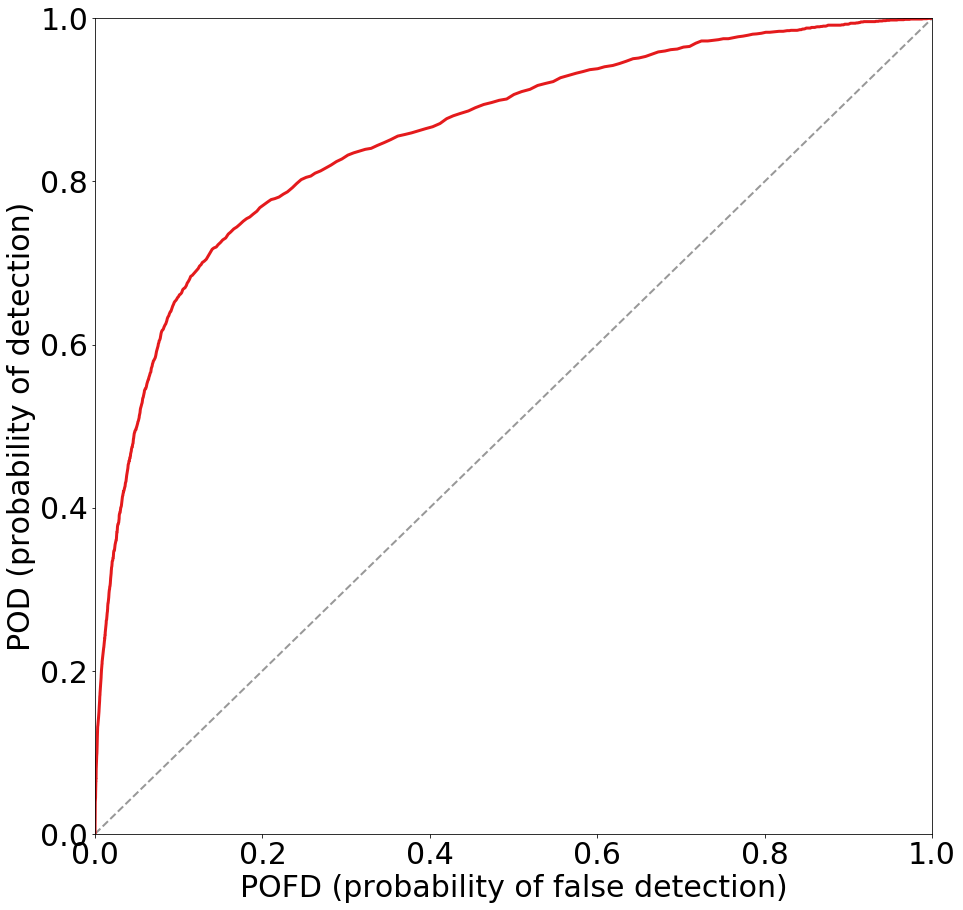

Area under ROC curve: 0.8561
Saving figure to: "/home/ryan.lagerquist/Downloads/ams2019_short_course/validation/roc_curve.jpg"...


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:226: RuntimeWarning: invalid value encountered in true_divide
  float(this_num_hits) / (this_num_hits + this_num_false_alarms)
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:65: RuntimeWarning: divide by zero encountered in reciprocal
  return (success_ratio_array ** -1 + pod_array ** -1 - 1.) ** -1
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:78: RuntimeWarning: divide by zero encountered in true_divide
  return pod_array / success_ratio_array
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ams_ml_python_course-0.1-py3.6.egg/module_4/performance_diagrams.py:78: RuntimeWarning: invalid value encountered in true_divide
  return pod_array

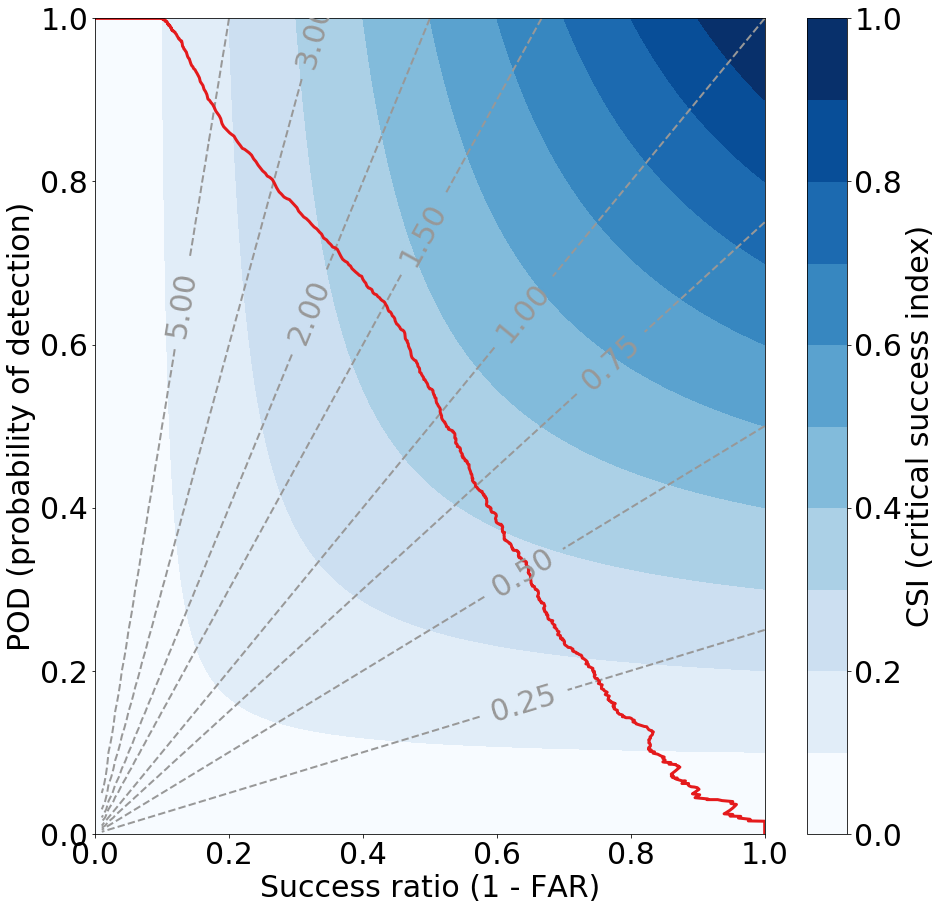

Saving figure to: "/home/ryan.lagerquist/Downloads/ams2019_short_course/validation/performance_diagram.jpg"...


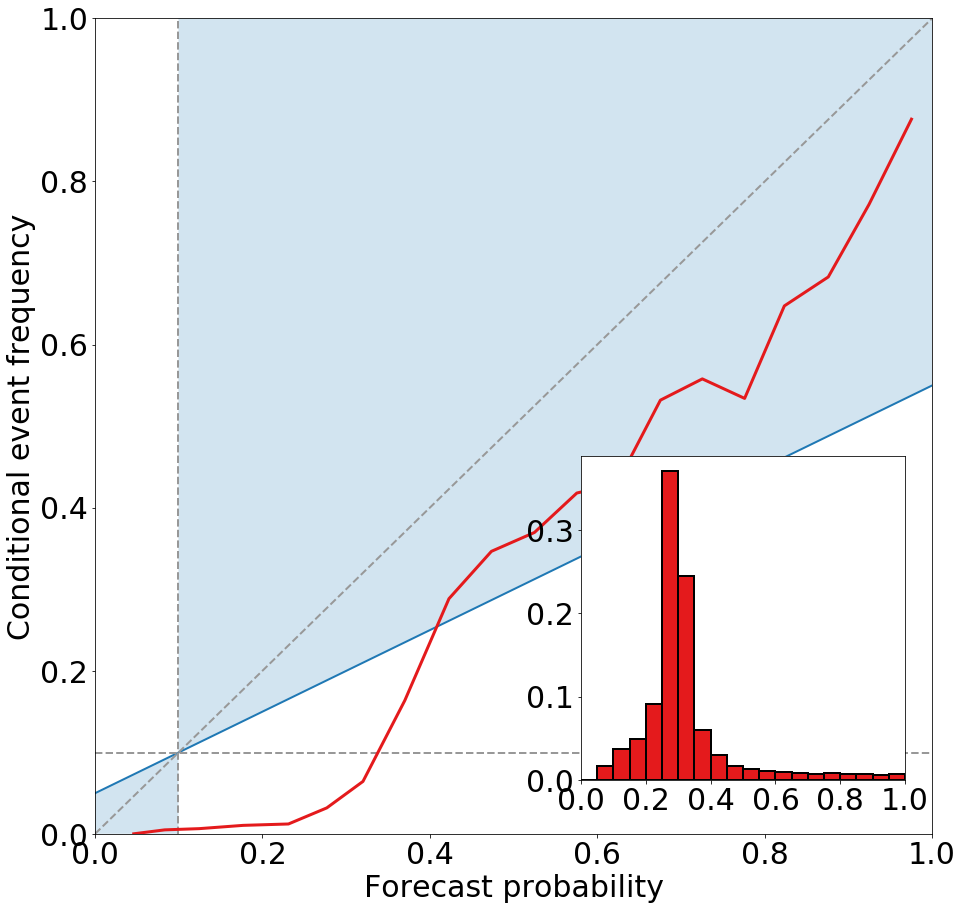

Saving figure to: "/home/ryan.lagerquist/Downloads/ams2019_short_course/validation/attributes_diagram.jpg"...


**************************************************




In [33]:
validation_image_dict = read_many_image_files(validation_file_names)
print(SEPARATOR_STRING)

validation_dir_name = '{0:s}/validation'.format(DEFAULT_OUTPUT_DIR_NAME)
evaluate_cnn(
    model_object=model_object, image_dict=validation_image_dict,
    model_metadata_dict=model_metadata_dict,
    output_dir_name=validation_dir_name)
print(SEPARATOR_STRING)

# Permutation Test

The next cell defines methods that run the permutation test on a trained CNN.  The permutation test is used to gauge the importance of each predictor variable.  There are two versions of the permutation test: Breiman (single-pass) and Lakshmanan (multi-pass).

In the Breiman version, only one predictor is permuted (randomized) at a time.  The amount by which the cost function increases when $x$ is permuted, is used to gauge the importance of $x$.  If the cost function remains the same or decreases when $x$ is permuted, $x$ is a useless predictor.  If the cost function increases slightly when $x$ is permuted, $x$ is a somewhat important predictor.  If the cost function skyrockets when $x$ is permuted, $x$ is a very important predictor.

In the Lakshmanan version, one or more predictors are permuted at a time.  The $1^{\textrm{st}}$ predictor permuted is the one that increases the cost function ($\epsilon$) the most with 0 other predictors permuted; the $2^{\textrm{nd}}$ predictor permuted is that which increases $\epsilon$ the most with the $1^{\textrm{st}}$ predictor already permuted; $\ldots$; and the $k^{\textrm{th}}$ predictor permuted is that which increases $\epsilon$ the most with the $1^{\textrm{st}}\ldots(k - 1)^{\textrm{th}}$ predictors already permuted.

In [41]:
def _get_binary_xentropy(target_values, forecast_probabilities):
    """Computes binary cross-entropy.

    This function satisfies the requirements for `cost_function` in the input to
    `run_permutation_test`.

    E = number of examples

    :param: target_values: length-E numpy array of target values (integer class
        labels).
    :param: forecast_probabilities: length-E numpy array with predicted
        probabilities of positive class (target value = 1).
    :return: cross_entropy: Cross-entropy.
    """

    forecast_probabilities[
        forecast_probabilities < MIN_PROBABILITY] = MIN_PROBABILITY
    forecast_probabilities[
        forecast_probabilities > MAX_PROBABILITY] = MAX_PROBABILITY

    return -1 * numpy.mean(
        target_values * numpy.log2(forecast_probabilities) +
        (1 - target_values) * numpy.log2(1 - forecast_probabilities)
    )


def permutation_test_for_cnn(
        model_object, image_dict, model_metadata_dict, output_pickle_file_name,
        cost_function=_get_binary_xentropy):
    """Runs permutation test on CNN (convolutional neural net).

    E = number of examples (storm objects)
    C = number of channels (predictor variables)

    :param model_object: Trained instance of `keras.models.Model`.
    :param image_dict: Dictionary created by `read_image_file` or
        `read_many_image_files`.  Should contain validation data (rather than
        training data), but this is not enforced.
    :param model_metadata_dict: Dictionary created by `train_cnn`.  This will
        ensure that data in `image_dict` are processed the exact same way as the
        training data for `model_object`.
    :param output_pickle_file_name: Path to output file.  `result_dict` (the
        output variable) will be saved here.

    :param cost_function: Cost function (used to evaluate model predictions).
        Must be negatively oriented (lower values are better).  Must have the
        following inputs and outputs.
    Input: target_values: length-E numpy array of target values (integer class
        labels).
    Input: forecast_probabilities: length-E numpy array with predicted
        probabilities of positive class (target value = 1).
    Output: cost: Scalar value.

    :return: result_dict: Dictionary with the following keys.
    result_dict['permuted_predictor_name_by_step']: length-C list with name of
        predictor permuted at each step.
    result_dict['highest_cost_by_step']: length-C numpy array with corresponding
        cost at each step.  highest_cost_by_step[m] = cost after permuting
        permuted_predictor_name_by_step[m].
    result_dict['original_cost']: Original cost (before any permutation).
    result_dict['predictor_names_step1']: length-C list of predictor names.
    result_dict['costs_step1']: length-C numpy array of corresponding costs.
        costs_step1[m] = cost after permuting only predictor_names_step1[m].
        This key and "predictor_names_step1" correspond to the Breiman version
        of the permutation test, while "permuted_predictor_name_by_step" and
        "highest_cost_by_step" correspond to the Lakshmanan version.
    """

    predictor_names = image_dict[PREDICTOR_NAMES_KEY]

    predictor_matrix, _ = normalize_images(
        predictor_matrix=image_dict[PREDICTOR_MATRIX_KEY] + 0.,
        predictor_names=image_dict[PREDICTOR_NAMES_KEY],
        normalization_dict=model_metadata_dict[NORMALIZATION_DICT_KEY])
    predictor_matrix = predictor_matrix.astype('float32')

    target_values = binarize_target_images(
        target_matrix=image_dict[TARGET_MATRIX_KEY],
        binarization_threshold=model_metadata_dict[BINARIZATION_THRESHOLD_KEY])

    # Get original cost (before permutation).
    these_probabilities = _apply_cnn(model_object=model_object,
                                     predictor_matrix=predictor_matrix)
    print(MINOR_SEPARATOR_STRING)

    original_cost = cost_function(target_values, these_probabilities)
    print('Original cost (no permutation): {0:.4e}\n'.format(original_cost))

    num_examples = len(target_values)
    remaining_predictor_names = predictor_names + []
    current_step_num = 0

    permuted_predictor_name_by_step = []
    highest_cost_by_step = []
    predictor_names_step1 = []
    costs_step1 = []

    while len(remaining_predictor_names) > 0:
        current_step_num += 1

        highest_cost = -numpy.inf
        best_predictor_name = None
        best_predictor_permuted_values = None

        for this_predictor_name in remaining_predictor_names:
            print(
                ('Trying predictor "{0:s}" at step {1:d} of permutation test...'
                 ).format(this_predictor_name, current_step_num)
            )

            this_predictor_index = predictor_names.index(this_predictor_name)
            this_predictor_matrix = predictor_matrix + 0.

            for i in range(num_examples):
                this_predictor_matrix[i, ..., this_predictor_index] = (
                    numpy.random.permutation(
                        this_predictor_matrix[i, ..., this_predictor_index])
                )

            print(MINOR_SEPARATOR_STRING)
            these_probabilities = _apply_cnn(
                model_object=model_object,
                predictor_matrix=this_predictor_matrix)
            print(MINOR_SEPARATOR_STRING)

            this_cost = cost_function(target_values, these_probabilities)
            print('Resulting cost = {0:.4e}'.format(this_cost))

            if current_step_num == 1:
                predictor_names_step1.append(this_predictor_name)
                costs_step1.append(this_cost)

            if this_cost < highest_cost:
                continue

            highest_cost = this_cost + 0.
            best_predictor_name = this_predictor_name + ''
            best_predictor_permuted_values = this_predictor_matrix[
                ..., this_predictor_index]

        permuted_predictor_name_by_step.append(best_predictor_name)
        highest_cost_by_step.append(highest_cost)

        # Remove best predictor from list.
        remaining_predictor_names.remove(best_predictor_name)

        # Leave values of best predictor permuted.
        this_predictor_index = predictor_names.index(best_predictor_name)
        predictor_matrix[
            ..., this_predictor_index] = best_predictor_permuted_values

        print('\nBest predictor = "{0:s}" ... new cost = {1:.4e}\n'.format(
            best_predictor_name, highest_cost))

    result_dict = {
        PERMUTED_PREDICTORS_KEY: permuted_predictor_name_by_step,
        HIGHEST_COSTS_KEY: numpy.array(highest_cost_by_step),
        ORIGINAL_COST_KEY: original_cost,
        STEP1_PREDICTORS_KEY: predictor_names_step1,
        STEP1_COSTS_KEY: numpy.array(costs_step1)
    }

    _create_directory(file_name=output_pickle_file_name)

    print('Writing results to: "{0:s}"...'.format(output_pickle_file_name))
    file_handle = open(output_pickle_file_name, 'wb')
    pickle.dump(result_dict, file_handle)
    file_handle.close()

    return result_dict

# Permutation Test: Example

The next cell runs the permutation test on validation data.

In [35]:
permutation_dir_name = '{0:s}/permutation_test'.format(
    DEFAULT_OUTPUT_DIR_NAME)
main_permutation_file_name = '{0:s}/permutation_results.p'.format(
    permutation_dir_name)

permutation_dict = permutation_test_for_cnn(
    model_object=model_object, image_dict=validation_image_dict,
    model_metadata_dict=model_metadata_dict,
    output_pickle_file_name=main_permutation_file_name)

Applying model to examples 0-999 of 25392...
Applying model to examples 1000-1999 of 25392...
Applying model to examples 2000-2999 of 25392...
Applying model to examples 3000-3999 of 25392...
Applying model to examples 4000-4999 of 25392...
Applying model to examples 5000-5999 of 25392...
Applying model to examples 6000-6999 of 25392...
Applying model to examples 7000-7999 of 25392...
Applying model to examples 8000-8999 of 25392...
Applying model to examples 9000-9999 of 25392...
Applying model to examples 10000-10999 of 25392...
Applying model to examples 11000-11999 of 25392...
Applying model to examples 12000-12999 of 25392...
Applying model to examples 13000-13999 of 25392...
Applying model to examples 14000-14999 of 25392...
Applying model to examples 15000-15999 of 25392...
Applying model to examples 16000-16999 of 25392...
Applying model to examples 17000-17999 of 25392...
Applying model to examples 18000-18999 of 25392...
Applying model to examples 19000-19999 of 25392...
Appl

Applying model to examples 12000-12999 of 25392...
Applying model to examples 13000-13999 of 25392...
Applying model to examples 14000-14999 of 25392...
Applying model to examples 15000-15999 of 25392...
Applying model to examples 16000-16999 of 25392...
Applying model to examples 17000-17999 of 25392...
Applying model to examples 18000-18999 of 25392...
Applying model to examples 19000-19999 of 25392...
Applying model to examples 20000-20999 of 25392...
Applying model to examples 21000-21999 of 25392...
Applying model to examples 22000-22999 of 25392...
Applying model to examples 23000-23999 of 25392...
Applying model to examples 24000-24999 of 25392...
Applying model to examples 25000-25391 of 25392...


--------------------------------------------------


Resulting cost = 5.9005e-01
Trying predictor "temperature_kelvins" at step 2 of permutation test...


--------------------------------------------------


Applying model to examples 0-999 of 25392...
Applying model to examples 1000

Applying model to examples 23000-23999 of 25392...
Applying model to examples 24000-24999 of 25392...
Applying model to examples 25000-25391 of 25392...


--------------------------------------------------


Resulting cost = 6.1746e-01

Best predictor = "reflectivity_dbz" ... new cost = 6.1746e-01

Writing results to: "/home/ryan.lagerquist/Downloads/ams2019_short_course/permutation_test/permutation_results.p"...


# Permutation Test: Plotting

The next cell defines method for plotting results of the permutation test.

In [38]:
def _label_bars_in_graph(axes_object, y_coords, y_strings):
    """Labels bars in graph.

    J = number of bars

    :param axes_object: Instance of `matplotlib.axes._subplots.AxesSubplot`.
        Will plot on these axes.
    :param y_coords: length-J numpy array with y-coordinates of bars.
    :param y_strings: length-J list of labels.
    """

    x_min, x_max = pyplot.xlim()
    x_coord_for_text = x_min + 0.01 * (x_max - x_min)

    for j in range(len(y_coords)):
        axes_object.text(
            x_coord_for_text, y_coords[j], y_strings[j], color='k',
            horizontalalignment='left', verticalalignment='center')


def plot_breiman_results(
        result_dict, output_file_name, plot_percent_increase=False):
    """Plots results of Breiman (single-pass) permutation test.

    :param result_dict: Dictionary created by `permutation_test_for_cnn`.
    :param output_file_name: Path to output file.  Figure will be saved here.
    :param plot_percent_increase: Boolean flag.  If True, x-axis will be
        percentage of original cost (before permutation).  If False, will be
        actual cost.
    """

    cost_values = result_dict[STEP1_COSTS_KEY]
    predictor_names = result_dict[STEP1_PREDICTORS_KEY]

    sort_indices = numpy.argsort(cost_values)
    cost_values = cost_values[sort_indices]
    predictor_names = [predictor_names[k] for k in sort_indices]

    x_coords = numpy.concatenate((
        numpy.array([result_dict[ORIGINAL_COST_KEY]]), cost_values
    ))

    if plot_percent_increase:
        x_coords = 100 * x_coords / x_coords[0]

    y_strings = ['No permutation'] + predictor_names
    y_coords = numpy.linspace(
        0, len(y_strings) - 1, num=len(y_strings), dtype=float)

    _, axes_object = pyplot.subplots(
        1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES)
    )

    axes_object.barh(
        y_coords, x_coords, color=BAR_GRAPH_FACE_COLOUR,
        edgecolor=BAR_GRAPH_EDGE_COLOUR, linewidth=BAR_GRAPH_EDGE_WIDTH)

    pyplot.yticks([], [])
    pyplot.ylabel('Predictor permuted')

    if plot_percent_increase:
        pyplot.xlabel('Cost (percentage of original)')
    else:
        pyplot.xlabel('Cost')

    _label_bars_in_graph(
        axes_object=axes_object, y_coords=y_coords, y_strings=y_strings)
    pyplot.show()

    _create_directory(file_name=output_file_name)
    print('Saving figure to: "{0:s}"...'.format(output_file_name))
    pyplot.savefig(output_file_name, dpi=FIGURE_RESOLUTION_DPI)
    pyplot.close()


def plot_lakshmanan_results(
        result_dict, output_file_name, plot_percent_increase=False):
    """Plots results of Lakshmanan (multi-pass) permutation test.

    :param result_dict: See doc for `plot_breiman_results`.
    :param output_file_name: Same.
    :param plot_percent_increase: Same.
    """

    x_coords = numpy.concatenate((
        numpy.array([result_dict[ORIGINAL_COST_KEY]]),
        result_dict[HIGHEST_COSTS_KEY]
    ))

    if plot_percent_increase:
        x_coords = 100 * x_coords / x_coords[0]

    y_strings = ['No permutation'] + result_dict[PERMUTED_PREDICTORS_KEY]
    y_coords = numpy.linspace(
        0, len(y_strings) - 1, num=len(y_strings), dtype=float
    )[::-1]

    _, axes_object = pyplot.subplots(
        1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES)
    )

    axes_object.barh(
        y_coords, x_coords, color=BAR_GRAPH_FACE_COLOUR,
        edgecolor=BAR_GRAPH_EDGE_COLOUR, linewidth=BAR_GRAPH_EDGE_WIDTH)

    pyplot.yticks([], [])
    pyplot.ylabel('Predictor permuted')

    if plot_percent_increase:
        pyplot.xlabel('Cost (percentage of original)')
    else:
        pyplot.xlabel('Cost')

    _label_bars_in_graph(
        axes_object=axes_object, y_coords=y_coords, y_strings=y_strings)
    pyplot.show()

    _create_directory(file_name=output_file_name)
    print('Saving figure to: "{0:s}"...'.format(output_file_name))
    pyplot.savefig(output_file_name, dpi=FIGURE_RESOLUTION_DPI)
    pyplot.close()

# Results of Breiman Permutation Test

The next cell plots the results of the Breiman (single-pass) permutation test.  The most important predictor (that whose permutation yields the greatest increase in the cost function) is at the top.

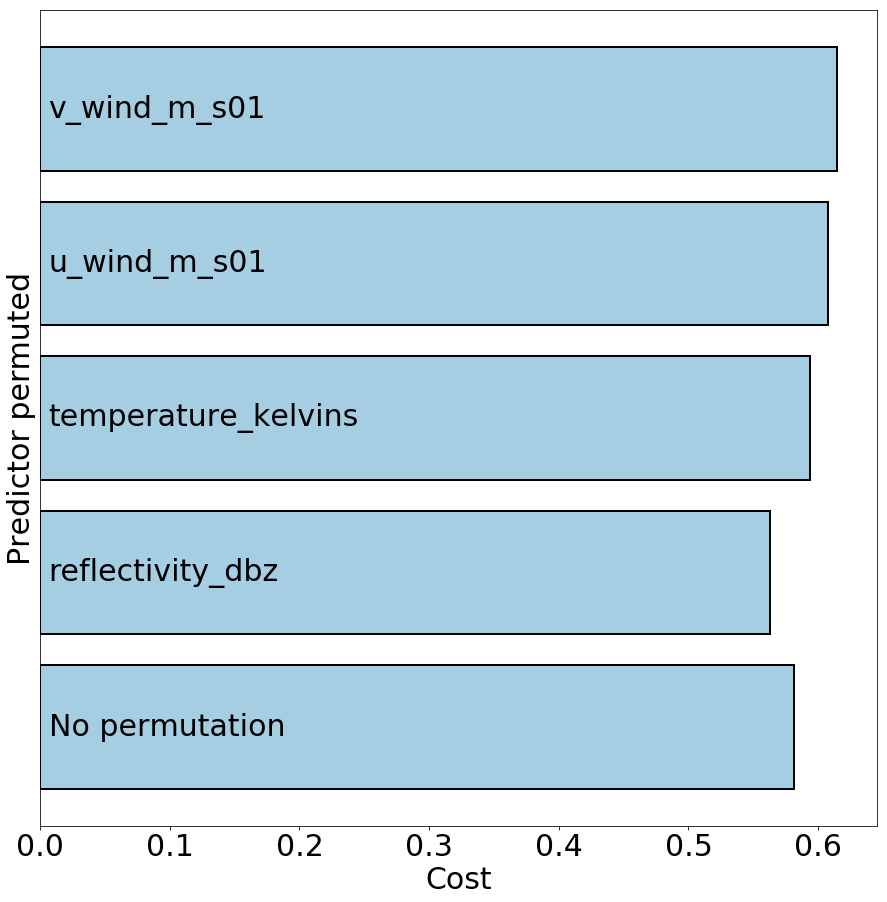

Saving figure to: "/home/ryan.lagerquist/Downloads/ams2019_short_course/permutation_test/breiman_results.jpg"...


In [39]:
breiman_file_name = '{0:s}/breiman_results.jpg'.format(permutation_dir_name)
plot_breiman_results(
    result_dict=permutation_dict, output_file_name=breiman_file_name,
    plot_percent_increase=False)

# Results of Lakshmanan Permutation Test

The next cell plots the results of the Lakshmanan (multi-pass) permutation test.  The most important predictor (the first one permuted) is at the top.

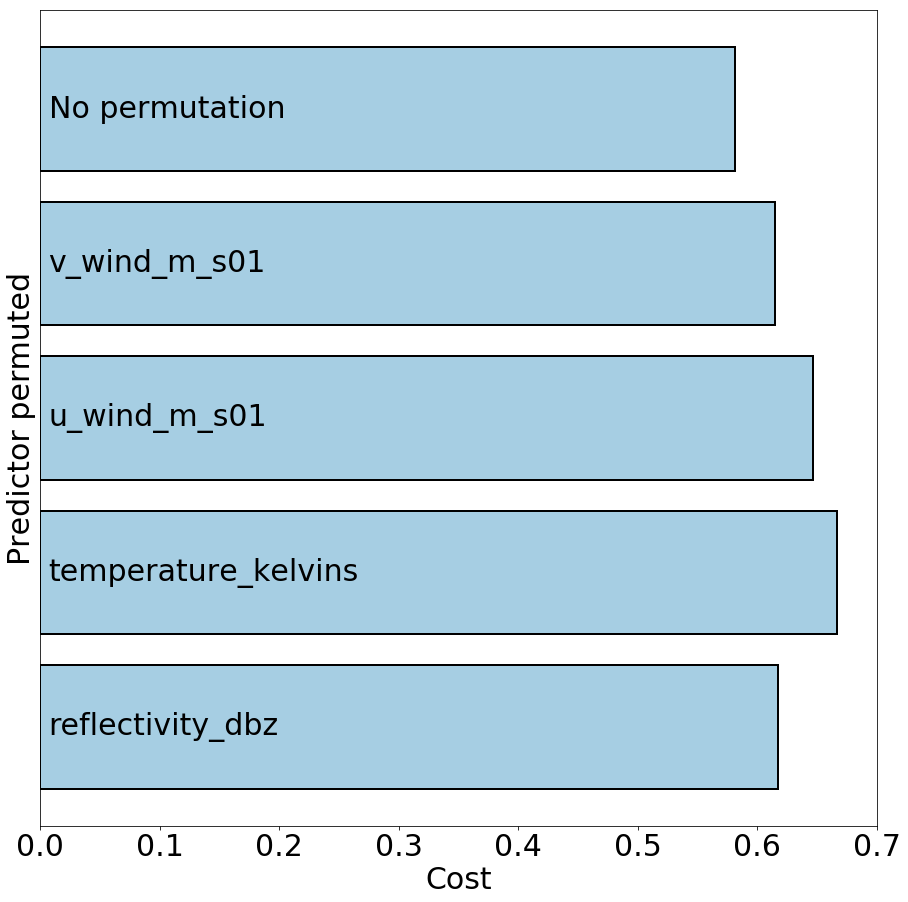

Saving figure to: "/home/ryan.lagerquist/Downloads/ams2019_short_course/permutation_test/lakshmanan_results.jpg"...


In [40]:
lakshmanan_file_name = '{0:s}/lakshmanan_results.jpg'.format(
    permutation_dir_name)
plot_lakshmanan_results(
    result_dict=permutation_dict, output_file_name=lakshmanan_file_name,
    plot_percent_increase=False)

# Backwards Optimization

The next cell defines methods that do backwards optimization.  The goal of backwards optimization is to create synthetic input data that maximize the activation of some model component.  "Some model component" could be any of the following.

 - Neuron activation: spatial position $(i, j)$ in channel $k$ of layer $L$
 - Channel activation: all spatial positions in channel $k$ of layer $L$
 - Layer activation: all spatial positions in all channels of layer $L$
 - Spatial activation: spatial position $(i, j)$ in all channels of layer $L$
 - Final prediction: probability that max future storm vorticity $\ge$ threshold

Backwards optimization uses gradient descent to create synthetic input data ($32 \times 32$ grids of reflectivity, temperature, $u$-wind, and $v$-wind).  Gradient descent requires an initial seed, which could be any of the following:

 - Uniform grids ($e.g.$, all zeros or all ones)
 - Random grids ($e.g.$, Gaussian noise)
 - A real dataset example

We will use real dataset examples, because these produce the most physically realistic output.

In [44]:
def _gradient_descent_for_bwo(
        model_object, loss_tensor, init_function_or_matrices, num_iterations,
        learning_rate):
    """Does gradient descent (the nitty-gritty part) for backwards optimization.

    :param model_object: Trained instance of `keras.models.Model`.
    :param loss_tensor: Keras tensor, defining the loss function to be
        minimized.
    :param init_function_or_matrices: Either a function or list of numpy arrays.

    If function, will be used to initialize input matrices.  See
    `create_gaussian_initializer` for an example.

    If list of numpy arrays, these are the input matrices themselves.  Matrices
    should be processed in the exact same way that training data were processed
    (e.g., normalization method).  Matrices must also be in the same order as
    training matrices, and the [q]th matrix in this list must have the same
    shape as the [q]th training matrix.

    :param num_iterations: Number of gradient-descent iterations (number of
        times that the input matrices are adjusted).
    :param learning_rate: Learning rate.  At each iteration, each input value x
        will be decremented by `learning_rate * gradient`, where `gradient` is
        the gradient of the loss function with respect to x.
    :return: list_of_optimized_input_matrices: length-T list of optimized input
        matrices (numpy arrays), where T = number of input tensors to the model.
        If the input arg `init_function_or_matrices` is a list of numpy arrays
        (rather than a function), `list_of_optimized_input_matrices` will have
        the exact same shape, just with different values.
    """

    if isinstance(model_object.input, list):
        list_of_input_tensors = model_object.input
    else:
        list_of_input_tensors = [model_object.input]

    num_input_tensors = len(list_of_input_tensors)

    list_of_gradient_tensors = K.gradients(loss_tensor, list_of_input_tensors)
    for i in range(num_input_tensors):
        list_of_gradient_tensors[i] /= K.maximum(
            K.sqrt(K.mean(list_of_gradient_tensors[i] ** 2)),
            K.epsilon()
        )

    inputs_to_loss_and_gradients = K.function(
        list_of_input_tensors + [K.learning_phase()],
        ([loss_tensor] + list_of_gradient_tensors)
    )

    if isinstance(init_function_or_matrices, list):
        list_of_optimized_input_matrices = copy.deepcopy(
            init_function_or_matrices)
    else:
        list_of_optimized_input_matrices = [None] * num_input_tensors

        for i in range(num_input_tensors):
            these_dimensions = numpy.array(
                [1] + list_of_input_tensors[i].get_shape().as_list()[1:],
                dtype=int)

            list_of_optimized_input_matrices[i] = init_function_or_matrices(
                these_dimensions)

    for j in range(num_iterations):
        these_outputs = inputs_to_loss_and_gradients(
            list_of_optimized_input_matrices + [0])

        if numpy.mod(j, 100) == 0:
            print('Loss after {0:d} of {1:d} iterations: {2:.2e}'.format(
                j, num_iterations, these_outputs[0]))

        for i in range(num_input_tensors):
            list_of_optimized_input_matrices[i] -= (
                these_outputs[i + 1] * learning_rate)

    print('Loss after {0:d} iterations: {1:.2e}'.format(
        num_iterations, these_outputs[0]))
    return list_of_optimized_input_matrices


def bwo_for_class(
        model_object, target_class, init_function_or_matrices,
        num_iterations=DEFAULT_NUM_BWO_ITERATIONS,
        learning_rate=DEFAULT_BWO_LEARNING_RATE):
    """Does backwards optimization to maximize probability of target class.

    :param model_object: Trained instance of `keras.models.Model`.
    :param target_class: Synthetic input data will be created to maximize
        probability of this class.
    :param init_function_or_matrices: See doc for `_gradient_descent_for_bwo`.
    :param num_iterations: Same.
    :param learning_rate: Same.
    :return: list_of_optimized_input_matrices: Same.
    """

    target_class = int(numpy.round(target_class))
    num_iterations = int(numpy.round(num_iterations))

    assert target_class >= 0
    assert num_iterations > 0
    assert learning_rate > 0.
    assert  learning_rate < 1.

    num_output_neurons = (
        model_object.layers[-1].output.get_shape().as_list()[-1]
    )

    if num_output_neurons == 1:
        assert target_class <= 1

        if target_class == 1:
            loss_tensor = K.mean(
                (model_object.layers[-1].output[..., 0] - 1) ** 2
            )
        else:
            loss_tensor = K.mean(
                model_object.layers[-1].output[..., 0] ** 2
            )
    else:
        assert target_class < num_output_neurons

        loss_tensor = K.mean(
            (model_object.layers[-1].output[..., target_class] - 1) ** 2
        )

    return _gradient_descent_for_bwo(
        model_object=model_object, loss_tensor=loss_tensor,
        init_function_or_matrices=init_function_or_matrices,
        num_iterations=num_iterations, learning_rate=learning_rate)

# Plotting Predictors

The next cell defines code that plots predictors (model grids of temperature, reflectivity, $u$-wind, and $v$-wind).

In [64]:
def _init_figure_panels(num_rows, num_columns, horizontal_space_fraction=0.1,
                        vertical_space_fraction=0.1):
    """Initializes paneled figure.

    :param num_rows: Number of panel rows.
    :param num_columns: Number of panel columns.
    :param horizontal_space_fraction: Horizontal space between panels (as
        fraction of panel size).
    :param vertical_space_fraction: Vertical space between panels (as fraction
        of panel size).
    :return: figure_object: Instance of `matplotlib.figure.Figure`.
    :return: axes_objects_2d_list: 2-D list, where axes_objects_2d_list[i][j] is
        the handle (instance of `matplotlib.axes._subplots.AxesSubplot`) for the
        [i]th row and [j]th column.
    """

    figure_object, axes_objects_2d_list = pyplot.subplots(
        num_rows, num_columns, sharex=False, sharey=False,
        figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES)
    )

    if num_rows == num_columns == 1:
        axes_objects_2d_list = [[axes_objects_2d_list]]
    elif num_columns == 1:
        axes_objects_2d_list = [[a] for a in axes_objects_2d_list]
    elif num_rows == 1:
        axes_objects_2d_list = [axes_objects_2d_list]

    pyplot.subplots_adjust(
        left=0.02, bottom=0.02, right=0.98, top=0.95,
        hspace=vertical_space_fraction, wspace=horizontal_space_fraction)

    return figure_object, axes_objects_2d_list


def _add_colour_bar(
        axes_object, colour_map_object, values_to_colour, min_colour_value,
        max_colour_value, colour_norm_object=None,
        orientation_string='vertical', extend_min=True, extend_max=True):
    """Adds colour bar to existing axes.

    :param axes_object: Existing axes (instance of
        `matplotlib.axes._subplots.AxesSubplot`).
    :param colour_map_object: Colour scheme (instance of
        `matplotlib.pyplot.cm`).
    :param values_to_colour: numpy array of values to colour.
    :param min_colour_value: Minimum value in colour map.
    :param max_colour_value: Max value in colour map.
    :param colour_norm_object: Instance of `matplotlib.colors.BoundaryNorm`,
        defining the scale of the colour map.  If `colour_norm_object is None`,
        will assume that scale is linear.
    :param orientation_string: Orientation of colour bar ("vertical" or
        "horizontal").
    :param extend_min: Boolean flag.  If True, the bottom of the colour bar will
        have an arrow.  If False, it will be a flat line, suggesting that lower
        values are not possible.
    :param extend_max: Same but for top of colour bar.
    :return: colour_bar_object: Colour bar (instance of
        `matplotlib.pyplot.colorbar`) created by this method.
    """

    if colour_norm_object is None:
        colour_norm_object = matplotlib.colors.Normalize(
            vmin=min_colour_value, vmax=max_colour_value, clip=False)

    scalar_mappable_object = pyplot.cm.ScalarMappable(
        cmap=colour_map_object, norm=colour_norm_object)
    scalar_mappable_object.set_array(values_to_colour)

    if extend_min and extend_max:
        extend_string = 'both'
    elif extend_min:
        extend_string = 'min'
    elif extend_max:
        extend_string = 'max'
    else:
        extend_string = 'neither'

    if orientation_string == 'horizontal':
        padding = 0.075
    else:
        padding = 0.05

    colour_bar_object = pyplot.colorbar(
        ax=axes_object, mappable=scalar_mappable_object,
        orientation=orientation_string, pad=padding, extend=extend_string,
        shrink=0.8)

    colour_bar_object.ax.tick_params(labelsize=FONT_SIZE)
    return colour_bar_object


def plot_predictor_2d(
        predictor_matrix, colour_map_object, colour_norm_object=None,
        min_colour_value=None, max_colour_value=None, axes_object=None):
    """Plots predictor variable on 2-D grid.

    If `colour_norm_object is None`, both `min_colour_value` and
    `max_colour_value` must be specified.

    M = number of rows in grid
    N = number of columns in grid

    :param predictor_matrix: M-by-N numpy array of predictor values.
    :param colour_map_object: Instance of `matplotlib.pyplot.cm`.
    :param min_colour_value: Minimum value in colour scheme.
    :param max_colour_value: Max value in colour scheme.
    :param axes_object: Instance of `matplotlib.axes._subplots.AxesSubplot`.
        Will plot on these axes.
    :return: axes_object: Instance of `matplotlib.axes._subplots.AxesSubplot` on
        which field was plotted.
    """

    if axes_object is None:
        _, axes_object = pyplot.subplots(
            1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES)
        )

    if colour_norm_object is not None:
        min_colour_value = colour_norm_object.boundaries[0]
        max_colour_value = colour_norm_object.boundaries[-1]

    axes_object.pcolormesh(
        predictor_matrix, cmap=colour_map_object, norm=colour_norm_object,
        vmin=min_colour_value, vmax=max_colour_value, shading='flat',
        edgecolors='None')

    axes_object.set_xticks([])
    axes_object.set_yticks([])

    _add_colour_bar(
        axes_object=axes_object, colour_map_object=colour_map_object,
        values_to_colour=predictor_matrix, min_colour_value=min_colour_value,
        max_colour_value=max_colour_value)


def plot_wind_2d(u_wind_matrix_m_s01, v_wind_matrix_m_s01, axes_object=None):
    """Plots wind velocity on 2-D grid.

    M = number of rows in grid
    N = number of columns in grid

    :param u_wind_matrix_m_s01: M-by-N numpy array of eastward components
        (metres per second).
    :param v_wind_matrix_m_s01: M-by-N numpy array of northward components
        (metres per second).
    :param axes_object: Instance of `matplotlib.axes._subplots.AxesSubplot`.
        Will plot on these axes.
    :return: axes_object: Instance of `matplotlib.axes._subplots.AxesSubplot` on
        which field was plotted.
    """

    if axes_object is None:
        _, axes_object = pyplot.subplots(
            1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES)
        )

    num_grid_rows = u_wind_matrix_m_s01.shape[0]
    num_grid_columns = u_wind_matrix_m_s01.shape[1]

    x_coords_unique = numpy.linspace(
        0, num_grid_columns, num=num_grid_columns + 1, dtype=float)
    x_coords_unique = x_coords_unique[:-1]
    x_coords_unique = x_coords_unique + numpy.diff(x_coords_unique[:2]) / 2
    
    y_coords_unique = numpy.linspace(
        0, num_grid_rows, num=num_grid_rows + 1, dtype=float)
    y_coords_unique = y_coords_unique[:-1]
    y_coords_unique = y_coords_unique + numpy.diff(y_coords_unique[:2]) / 2

    x_coord_matrix, y_coord_matrix = numpy.meshgrid(x_coords_unique,
                                                    y_coords_unique)

    speed_matrix_m_s01 = numpy.sqrt(u_wind_matrix_m_s01 ** 2
                                    + v_wind_matrix_m_s01 ** 2)

    axes_object.barbs(
        x_coord_matrix, y_coord_matrix,
        u_wind_matrix_m_s01 * METRES_PER_SECOND_TO_KT,
        v_wind_matrix_m_s01 * METRES_PER_SECOND_TO_KT,
        speed_matrix_m_s01 * METRES_PER_SECOND_TO_KT, color='k', length=6,
        sizes={'emptybarb': 0.1}, fill_empty=True, rounding=False)


def plot_many_predictors_2d(
        predictor_matrix, predictor_names, min_colour_temp_kelvins,
        max_colour_temp_kelvins):
    """Plots many predictor variables on 2-D grid.

    M = number of rows in grid
    N = number of columns in grid
    C = number of predictors

    :param predictor_matrix: M-by-N-by-C numpy array of predictor values.
    :param predictor_names: length-C list of predictor names.
    :param min_colour_temp_kelvins: Minimum value in temperature colour scheme.
    :param max_colour_temp_kelvins: Max value in temperature colour scheme.
    :return: axes_objects_2d_list: See doc for `_init_figure_panels`.
    """

    u_wind_matrix_m_s01 = predictor_matrix[
        ..., predictor_names.index(U_WIND_NAME)]
    v_wind_matrix_m_s01 = predictor_matrix[
        ..., predictor_names.index(V_WIND_NAME)]

    non_wind_predictor_names = [
        p for p in predictor_names if p not in [U_WIND_NAME, V_WIND_NAME]
    ]

    _, axes_objects_2d_list = _init_figure_panels(
        num_rows=len(non_wind_predictor_names), num_columns=1)

    for m in range(len(non_wind_predictor_names)):
        this_predictor_index = predictor_names.index(
            non_wind_predictor_names[m])

        if non_wind_predictor_names[m] == REFLECTIVITY_NAME:
            this_colour_norm_object = REFL_COLOUR_NORM_OBJECT
            this_min_colour_value = None
            this_max_colour_value = None
        else:
            this_colour_norm_object = None
            this_min_colour_value = min_colour_temp_kelvins + 0.
            this_max_colour_value = max_colour_temp_kelvins + 0.

        plot_predictor_2d(
            predictor_matrix=predictor_matrix[..., this_predictor_index],
            colour_map_object=PREDICTOR_TO_COLOUR_MAP_DICT[
                non_wind_predictor_names[m]],
            colour_norm_object=this_colour_norm_object,
            min_colour_value=this_min_colour_value,
            max_colour_value=this_max_colour_value,
            axes_object=axes_objects_2d_list[m][0])

        plot_wind_2d(u_wind_matrix_m_s01=u_wind_matrix_m_s01,
                     v_wind_matrix_m_s01=v_wind_matrix_m_s01,
                     axes_object=axes_objects_2d_list[m][0])

        axes_objects_2d_list[m][0].set_title(non_wind_predictor_names[m])

    pyplot.show()
    return axes_objects_2d_list

# Plotting Predictors: Example 1

The next cell plots all predictors for the first validation example.

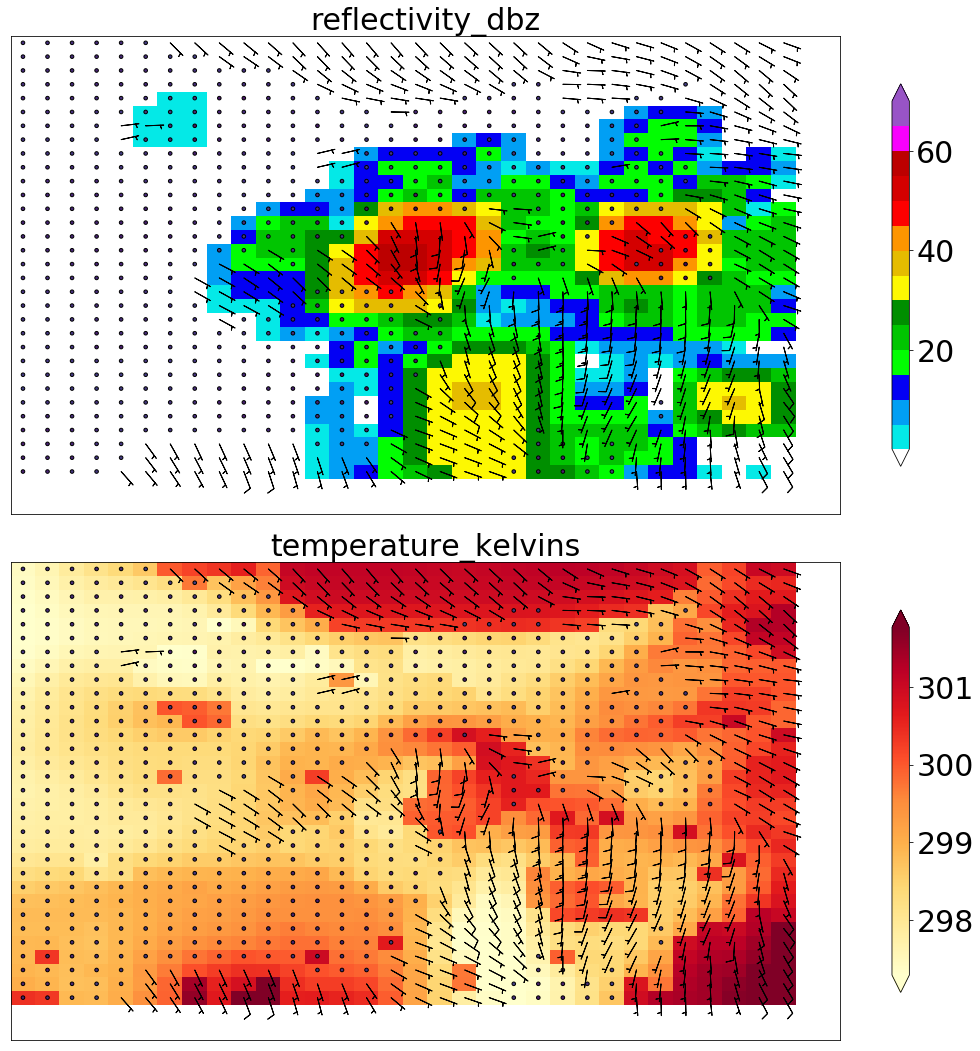

[[<matplotlib.axes._subplots.AxesSubplot at 0x7fc1506f9ef0>],

In [65]:
predictor_matrix = validation_image_dict[PREDICTOR_MATRIX_KEY][0, ...]
predictor_names = validation_image_dict[PREDICTOR_NAMES_KEY]
temperature_matrix_kelvins = predictor_matrix[
    ..., predictor_names.index(TEMPERATURE_NAME)]

plot_many_predictors_2d(
    predictor_matrix=predictor_matrix,
    predictor_names=predictor_names,
    min_colour_temp_kelvins=numpy.percentile(temperature_matrix_kelvins, 1),
    max_colour_temp_kelvins=numpy.percentile(temperature_matrix_kelvins, 99)
)